# RAG

In this notebook, i will do some experimentation before deploying my rag as a tool on mcp, here you will find all the steps that i walked into before reaching the final structure.

In [2]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_=load_dotenv(find_dotenv()) # read local .env file

openai.api_key =os.environ['OPENAI_API_KEY']

## Document Loaders

we will start by loading our pdfs

ref: https://python.langchain.com/docs/how_to/document_loader_directory/

For the loading, I starting initailly with the pypdf loader, however it field since the structure of the pdf involved complex equations, images based pdfs, and other complexities. You may check the feasibility tests in the testing_rags notebook

In [2]:
# pip install langchain langchain-community langchain-text-splitters  pymupdf

from pathlib import Path
import re
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

BASE_DIR=Path("../../Courses/signals and systems")   

# load every pdf under the course folder 
loader=DirectoryLoader(
    str(BASE_DIR),
    glob="**/*.pdf",
    loader_cls=PyMuPDFLoader,
)


In [3]:
BASE_DIR.name

'signals and systems'

In [4]:
raw_docs=loader.load()

In [5]:
len(raw_docs)  # number of pages loaded

570

In [6]:
print(raw_docs[0])

page_content='Assignment 01
Lectures: 2, 3, 4
Exercise 1: Plot the following continuous-time signals:
1. f(t) = −6rect(t) cos(3πt).
2. f(t) = rect(t)tri(t + 1
2).
3. f(t) = −ramp(t)u(t −2).
4. f(t) = 2tri(2t
3 ) + 3rect( t
3).
Exercise 2: Consider the systems described by the following input-output
relations x(t) →y(t):
1. y(t) = x(t −1) −x(t −5).
2. y(t) = |t|x(t).
3. y(t) = (x(t))2 −x(t −1).
Study the linearity, time-invariance and causality of the above systems. Jus-
tify your answers.
Exercise 3: Consider the continuous-time signal f(t) shown in the ﬁgure
below:
1. Plot: −2f(t), f(t −3) and f(−t).
2. Plot: −3f
  2t+1
5

, f(−2t + 1) and f
  −3t+1
5

.
1' metadata={'producer': 'MiKTeX GPL Ghostscript 9.19', 'creator': 'dvips(k) 5.997 Copyright 2017 Radical Eye Software', 'creationdate': '2023-01-16T09:42:17+02:00', 'source': '..\\..\\Courses\\signals and systems\\Assigments\\Assignment1_Lecture2_Lecture3_Lecture4.pdf', 'file_path': '..\\..\\Courses\\signals and systems\\Assigments

In [7]:
doc_sample=raw_docs[0]
path_sample=Path(doc_sample.metadata['source'])
print([x.lower() for x in path_sample.parts])

['..', '..', 'courses', 'signals and systems', 'assigments', 'assignment1_lecture2_lecture3_lecture4.pdf']


In [8]:
CHAPTER_DIR_RE      = re.compile(r"chapter\s*(\d+)", re.I)
LECTURE_IN_NAME_RE  = re.compile(r"[ _-]lecture\s*(\d+)", re.I)
ASSIGNMENT_RE       = re.compile(r"assignment\s*(\d+)", re.I)
EXAM_DIR_RE         = re.compile(r"exam\s*(\d+)", re.I)
TERM_RE             = re.compile(r"(spring|summer|fall|autumn|winter)[ _-]?(\d{4})", re.I)
SOLUTION_RE         = re.compile(r"solution", re.I)

chapter_name_set = set()
exams_name_set = set()

for d in raw_docs:
    p = Path(d.metadata["source"])
    parts_lower = [x.lower() for x in p.parts]
    parts_joined = "/".join(parts_lower)

    # defaults
    category = "other"
    chapter_num = None
    lecture_number = None
    lecture_min = None
    lecture_max = None
    has_multiple = False
    assignment_num = None
    is_solution = False
    exam_num = None
    term_year = None

    if "chapters" in parts_lower:
        category = "chapters"
        m = CHAPTER_DIR_RE.search(p.parent.name)
        chapter_num = int(m.group(1)) if m else None
        lec_nums = sorted({int(n) for n in LECTURE_IN_NAME_RE.findall(p.name)})
        if lec_nums:
            has_multiple = len(lec_nums) > 1
            if len(lec_nums) == 1:
                lecture_number = lec_nums[0]
            lecture_min, lecture_max = min(lec_nums), max(lec_nums)

    elif "syllabus" in parts_lower:
        category = "syllabus"

    elif "assignments solutions" in parts_joined:
        category = "assignments_solutions"
        is_solution = True
        m = ASSIGNMENT_RE.search(p.stem)
        assignment_num = int(m.group(1)) if m else None
        lec_nums = sorted({int(n) for n in LECTURE_IN_NAME_RE.findall(p.name)})
        if lec_nums:
            has_multiple = len(lec_nums) > 1
            if len(lec_nums) == 1:
                lecture_number = lec_nums[0]
            lecture_min, lecture_max = min(lec_nums), max(lec_nums)

    elif "assignments" in parts_lower:
        category = "assignments"
        m = ASSIGNMENT_RE.search(p.stem)
        assignment_num = int(m.group(1)) if m else None
        lec_nums = sorted({int(n) for n in LECTURE_IN_NAME_RE.findall(p.name)})
        if lec_nums:
            has_multiple = len(lec_nums) > 1
            if len(lec_nums) == 1:
                lecture_number = lec_nums[0]
            lecture_min, lecture_max = min(lec_nums), max(lec_nums)

    elif "previouses" in parts_lower or "exams" in parts_lower:
        category = "exams"
        mdir = None
        for anc in [p] + list(p.parents):
            mdir = EXAM_DIR_RE.search(anc.name)
            if mdir:
                break
        exam_num = int(mdir.group(1)) if mdir else None
        if exam_num is not None:
            exams_name_set.add(exam_num)

        mterm = TERM_RE.search(p.stem)
        if mterm:
            term_year = int(mterm.group(2))
        is_solution = bool(SOLUTION_RE.search(p.stem))

    d.metadata.update({
        "course_id": BASE_DIR.name,
        "category": category,                  # chapters | syllabus | assignments | assignments_solutions | exams | other
        "chapter": chapter_num,                # int or None
        "lecture_number": lecture_number,      # int or None
        "lecture_min": lecture_min,            # int or None
        "lecture_max": lecture_max,            # int or None
        "has_multiple_lectures": has_multiple, # bool
        "assignment_number": assignment_num,   # int or None
        "exam_number": exam_num,               # int or None
        "term_year": term_year,                # int or None
        "is_solution": is_solution,            # bool
        "doc_id": p.stem,
        "filename": p.name,
        "relpath": str(p.relative_to(BASE_DIR)),
    })


In [9]:
exams_name_set # checking the exams that were returned

{1, 2}

In [10]:
chapter_name_set # double checking

set()

In [11]:
# this is the initial function i used when i was trying out stuff



# now we need to update our meta data
# chapter_name_set= set()
# for d in raw_docs:
#     p=Path(d.metadata["source"])         
#     parts=[x.lower() for x in p.parts]

#     # checking the category of our data
#     if "chapters" in parts:
#         category="chapters"
#         chap_name=p.parent.name   
#         chapter_name_set.add(chap_name) # keep track of our chapters that are loaded     
#         m=re.search(r"chapter\s*(\d+)", chap_name, re.I) # this regex was provided by chatgpt
#         chapter_num=int(m.group(1)) if m else None
#     elif "syllabus" in parts:
#         category="syllabus"
#         chapter_num=None
#     elif "previouses" in parts:
#         category="previouses"
#         chapter_num=None
#     else:
#         category="other"
#         chapter_num=None

#     d.metadata.update({
#         "course_id":BASE_DIR.name,                # "signals and systems"
#         "category":category,                      # chapters | syllabus | previouses
#         "chapter":chapter_num,             
#         "doc_id": p.stem,
#         "filename":p.name,
#         "relpath":str(p.relative_to(BASE_DIR))
#     })


## Document Splittings

In [12]:

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, # Maximum size of chunks to return
    chunk_overlap= 50 # Overlap in characters between chunks
)
docs=r_splitter.split_documents(raw_docs) # we are dealing with a list of documents not text, thats why we did not use split_text

In [13]:
len(raw_docs) # number of loaded pages

570

In [14]:
len(docs) # number of chunks

685

In [15]:
# checking the consistency of our metadata
for i in range(30):
    print(docs[i].metadata['source'])

..\..\Courses\signals and systems\Assigments\Assignment1_Lecture2_Lecture3_Lecture4.pdf
..\..\Courses\signals and systems\Assigments\Assignment1_Lecture2_Lecture3_Lecture4.pdf
..\..\Courses\signals and systems\Assigments\Assignment1_Lecture2_Lecture3_Lecture4.pdf
..\..\Courses\signals and systems\Assigments\Assignment1_Lecture2_Lecture3_Lecture4.pdf
..\..\Courses\signals and systems\Assigments\Assignment1_Lecture2_Lecture3_Lecture4.pdf
..\..\Courses\signals and systems\Assigments\Assignment2_Lecture5_Lecture6.pdf
..\..\Courses\signals and systems\Assigments\Assignment2_Lecture5_Lecture6.pdf
..\..\Courses\signals and systems\Assigments\Assignment2_Lecture5_Lecture6.pdf
..\..\Courses\signals and systems\Assigments\Assignment2_Lecture5_Lecture6.pdf
..\..\Courses\signals and systems\Assigments\Assignment3_Lecture7_Lecture8_Lecture9.pdf
..\..\Courses\signals and systems\Assigments\Assignment3_Lecture7_Lecture8_Lecture9.pdf
..\..\Courses\signals and systems\Assigments\Assignment3_Lecture7_Le

In [16]:
print(docs[0].page_content)


Assignment 01
Lectures: 2, 3, 4
Exercise 1: Plot the following continuous-time signals:
1. f(t) = −6rect(t) cos(3πt).
2. f(t) = rect(t)tri(t + 1
2).
3. f(t) = −ramp(t)u(t −2).
4. f(t) = 2tri(2t
3 ) + 3rect( t
3).
Exercise 2: Consider the systems described by the following input-output
relations x(t) →y(t):
1. y(t) = x(t −1) −x(t −5).
2. y(t) = |t|x(t).
3. y(t) = (x(t))2 −x(t −1).
Study the linearity, time-invariance and causality of the above systems. Jus-
tify your answers.


In [17]:
len(docs[0].page_content.strip())

479

## Vector Stores and Embeddings

In [3]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()

In [19]:
from langchain.vectorstores import Chroma
persist_directory = '../docs/chroma/'
vectordb = Chroma.from_documents(
    documents=docs,
    embedding=embedding,
    collection_name="ele430_signals",
    persist_directory=persist_directory
)

## Retrieval

In [374]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [375]:
metadata_field_info = [
    AttributeInfo(name="category", type="string", description="chapters | syllabus | assignments | assignments_solutions | previouses"),
    AttributeInfo(name="chapter", type="integer", description="Chapter number"),
    AttributeInfo(name="lecture_number", type="integer", description="Exact lecture number when the file is a single lecture"),
    AttributeInfo(name="lecture_min", type="integer", description="Smallest lecture number contained in the file"),
    AttributeInfo(name="lecture_max", type="integer", description="Largest lecture number contained in the file"),
    AttributeInfo(name="assignment_number", type="integer", description="Assignment index"),
    AttributeInfo(name="is_solution", type="bool", description="True if solution file"),
    AttributeInfo(name="exam_number", type="integer", description="Exam index"),
    AttributeInfo(name="term_year", type="integer", description="Year for exams"),
]

In [376]:
from langchain.retrievers.self_query.base import SelfQueryRetriever

In [377]:
from langchain_openai import OpenAI
document_content_description = "Signals and Systems"
llm = OpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_contents=document_content_description,
    metadata_field_info=metadata_field_info,
    verbose=True
)

In [378]:
from langchain.chains import  ConversationalRetrievalChain

In [379]:
qa = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    chain_type="map_reduce", # depending on the state, might be refine (mostprobably)
    return_source_documents=True,
    )

In [380]:
# Ask a Lecture 1 question (will trigger the self-query filter)
question = (
    """
    based on the syllabus, in which lectures is the fourier series discussed.
    """
)

resp = qa({"question": question, "chat_history": []})

print("ANSWER:\n", resp["answer"], "\n")

print("SOURCES:")
for i, doc in enumerate(resp.get("source_documents", []), 1):
    md = doc.metadata
    page = md.get("page") or md.get("page_or_slide") or md.get("page_label")
    print(
        f"[{i}] {md.get('category')} | chapter={md.get('chapter')} "
        f"| lecture#={md.get('lecture_number')} | range={md.get('lecture_min')}-{md.get('lecture_max')} "
        f"| page={page} | file={md.get('filename')} | rel={md.get('relpath')}"
    )


ANSWER:
  The Fourier series is discussed in lectures 7, 8, and 9. 

SOURCES:
[1] syllabus | chapter=None | lecture#=None | range=None-None | page=3 | file=syllabus ELE430.pdf | rel=syllabus\syllabus ELE430.pdf
[2] syllabus | chapter=None | lecture#=None | range=None-None | page=1 | file=syllabus ELE430.pdf | rel=syllabus\syllabus ELE430.pdf
[3] syllabus | chapter=None | lecture#=None | range=None-None | page=2 | file=syllabus ELE430.pdf | rel=syllabus\syllabus ELE430.pdf
[4] syllabus | chapter=None | lecture#=None | range=None-None | page=None | file=syllabus ELE430.pdf | rel=syllabus\syllabus ELE430.pdf


The advantage of this adopted retriver is that we will be the stone of our approach for performing an educated search in our data, without scraping all the files.

# Creating our RAG built up method

In [ ]:

from typing import Sequence, Union
from langchain_core.language_models import BaseLanguageModel
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain_core.vectorstores import VectorStore
from langchain.chains.conversational_retrieval.base import BaseConversationalRetrievalChain

def educated_retriever(llm: BaseLanguageModel,
                       metadata_field_info: Sequence[Union[AttributeInfo, dict]],
                       document_content: str,
                       vectordb: VectorStore,
                       chain_type: str ="map reduce") -> BaseConversationalRetrievalChain:
    """_summary_
    Builds a conversational retrieval QA pipeline by combining a SelfQueryRetriever (LLM-guided vector search + structured metadata filters) with a ConversationalRetrievalChain. 
    Given metadata field descriptions and a natural-language summary of the document contents, it lets the agent translate user questions into filtered vector store queries, handle follow-ups using chat history, and return answers with cited source documents.

    Inputs:
    - llm (BaseLanguageModel): LLM used to infer filters and generate answers.
    - metadata_field_info (Sequence[Union[AttributeInfo, dict]]): Descriptions of filterable metadata fields (name/type/description/constraints).
    - document_content (str): Plain-language description of what each document represents.
    - vectordb (VectorStore): Backing vector store containing embedded documents.
    - chain_type (str, optional): QA chain type (e.g., "stuff", "map_reduce", "refine", "map_rerank"). Default: "map reduce".

    Return type:
    - BaseConversationalRetrievalChain — a callable chain expecting {"question": str, "chat_history": list[tuple[str, str]]}
    and returning {"answer": str, "source_documents": List[Document], ...}.
    """

    retriever = SelfQueryRetriever.from_llm(
        llm,
        vectordb,
        document_contents=document_content,
        metadata_field_info=metadata_field_info,
        verbose=True)
    qa = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    chain_type=chain_type, # depending on the state, might be refine (mostprobably)
    return_source_documents=True,
    )
    return qa

## RAG CLASS

In [382]:
from typing import TypedDict, List, Tuple, Dict, Any, Optional
from langchain.chains.query_constructor.base import AttributeInfo
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, START,END

Using chatgpt, i wrapped up all the above setup in a class code

In [384]:
from langgraph.graph import START, MessagesState, StateGraph
class AgentState(MessagesState):
    """The state of the agent."""
    response: str
    

In [ ]:
from langchain.tools import BaseTool
from pydantic import BaseModel, Field
from typing import Optional, Type, Annotated

class RAGSearchInput(BaseModel):
    """Input schema for the RAG search tool"""
    query: str = Field(..., description="The query to search for in the course materials")
    course_path: Optional[str] = Field(default=None, description="Path to the course materials")
    chain_type: Optional[str] = Field(default="map_reduce", description="Chain type for the QA system")

class RAGSearchTool(BaseTool):
    """
    A tool that implements educated RAG search capabilities for course materials.
    Built on top of the educated_retriever implementation.
    """
    name: Annotated[str, Field(description="Name of the tool")] = "educated_course_material_search"
    description: Annotated[str, Field(description="Description of the tool")] = """
    Search through course materials using an educated RAG approach.
    Uses metadata filtering and conversational capabilities to provide relevant information.
    """
    args_schema: Type[BaseModel] = RAGSearchInput
    default_course_path: Path = None
    def __init__(self, default_course_path: Optional[Path] = None):
        super().__init__()
        self.default_course_path = default_course_path or Path("../../Courses/signals and systems")
        self._qa_chain = None
        self._metadata_field_info = None
        self._vectordb = None
        
    def _initialize_components(self):
        """Initialize the RAG components if not already initialized"""
        if self._qa_chain is None:
            # [Rest of the implementation remains the same]
            # Load documents
            loader = DirectoryLoader(
                str(self.default_course_path),
                glob="**/*.pdf",
                loader_cls=PyMuPDFLoader,
            )
            raw_docs = loader.load()
            
            # Process metadata
            for d in raw_docs:
                p = Path(d.metadata["source"])
                parts_lower = [x.lower() for x in p.parts]
                
                # Initialize metadata with defaults
                metadata = {
                    "category": "other",
                    "chapter": None,
                    "lecture_number": None,
                    "lecture_min": None,
                    "lecture_max": None,
                    "has_multiple_lectures": False,
                    "assignment_number": None,
                    "is_solution": False,
                    "exam_number": None,
                    "term_year": None,
                }
                
                # Update metadata based on file location
                if "chapters" in parts_lower:
                    metadata["category"] = "chapters"
                    m = re.search(r"chapter\s*(\d+)", p.parent.name, re.I)
                    metadata["chapter"] = int(m.group(1)) if m else None
                    lec_nums = sorted({int(n) for n in re.findall(r"lecture\s*(\d+)", p.name, re.I)})
                    if lec_nums:
                        metadata["has_multiple_lectures"] = len(lec_nums) > 1
                        metadata["lecture_number"] = lec_nums[0] if len(lec_nums) == 1 else None
                        metadata["lecture_min"], metadata["lecture_max"] = min(lec_nums), max(lec_nums)
                elif "syllabus" in parts_lower:
                    metadata["category"] = "syllabus"
                elif "assignments" in parts_lower:
                    metadata["category"] = "assignments"
                    if "solutions" in parts_lower:
                        metadata["is_solution"] = True
                    m = re.search(r"assignment\s*(\d+)", p.stem, re.I)
                    metadata["assignment_number"] = int(m.group(1)) if m else None
                elif any(x in parts_lower for x in ["previouses", "exams"]):
                    metadata["category"] = "exams"
                    m = re.search(r"exam\s*(\d+)", p.name, re.I)
                    metadata["exam_number"] = int(m.group(1)) if m else None
                    m_term = re.search(r"(spring|fall)\s*(\d{4})", p.stem, re.I)
                    if m_term:
                        metadata["term_year"] = int(m_term.group(2))
                    metadata["is_solution"] = bool(re.search(r"solution", p.stem, re.I))
                
                d.metadata.update(metadata)
            
            # Split documents
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=1500,
                chunk_overlap=250
            )
            split_docs = splitter.split_documents(raw_docs)
            
            # Create vector store
            embeddings = OpenAIEmbeddings()
            self._vectordb = Chroma.from_documents(
                documents=split_docs,
                embedding=embeddings,
                collection_name="course_materials",
                persist_directory="../docs/chroma/"
            )
            
            # Define metadata fields
            self._metadata_field_info = [
                AttributeInfo(name="category", type="string", 
                            description="Type of document: chapters | syllabus | assignments | exams"),
                AttributeInfo(name="chapter", type="integer", 
                            description="Chapter number"),
                AttributeInfo(name="lecture_number", type="integer", 
                            description="Specific lecture number"),
                AttributeInfo(name="lecture_min", type="integer", 
                            description="First lecture number in range"),
                AttributeInfo(name="lecture_max", type="integer", 
                            description="Last lecture number in range"),
                AttributeInfo(name="assignment_number", type="integer", 
                            description="Assignment number"),
                AttributeInfo(name="is_solution", type="boolean", 
                            description="Whether document is a solution"),
                AttributeInfo(name="exam_number", type="integer", 
                            description="Exam number"),
                AttributeInfo(name="term_year", type="integer", 
                            description="Academic year")
            ]
            
            # Create the QA chain using educated_retriever
            llm = ChatOpenAI(temperature=0)
            self._qa_chain = educated_retriever(
                llm=llm,
                metadata_field_info=self._metadata_field_info,
                document_content="Course materials for Signals and Systems",
                vectordb=self._vectordb,
                chain_type="map_reduce"
            )
    
    def _run(
        self,
        query: str,
        course_path: Optional[str] = None,
        chain_type: Optional[str] = None,          # kept for compatibility; ignored unless you want to rebuild
        category: Optional[str] = None,
        chapter: Optional[int] = None,
        lecture_number: Optional[int] = None,
        k: int = 5,
    ) -> str:
        """Execute the RAG search (optionally constrained by metadata filters)."""

        # Allow switching course on the fly
        if course_path:
            self.default_course_path = Path(course_path)
            self._qa_chain = None  # Force re-init for new corpus

        # Make sure components exist
        self._initialize_components()

        # Build a HARD filter (ANDed with SQR’s inferred filter)
        # Keep it Chroma-friendly: primitives + {$lte,$gte} for ranges
        flt = {}
        if category:
            flt["category"] = category
        if chapter is not None:
            flt["chapter"] = chapter
        # If a single lecture number is requested, match exact or within [lecture_min, lecture_max]
        if lecture_number is not None:
            # Use an $or across exact number OR range gate (Chroma supports $and/$or/$lte/$gte)
            lecture_gate = {
                "$or": [
                    {"lecture_number": lecture_number},
                    {"$and": [
                        {"lecture_min": {"$lte": lecture_number}},
                        {"lecture_max": {"$gte": lecture_number}},
                    ]}
                ]
            }
            # Merge $or with any existing filter via $and (if needed)
            if flt:
                flt = {"$and": [flt, lecture_gate]}
            else:
                flt = lecture_gate

        # Stash current search kwargs, then apply ours temporarily
        retr = self._qa_chain.retriever
        orig_kwargs = dict(getattr(retr, "search_kwargs", {}) or {})
        try:
            new_kwargs = {"k": k}
            if flt:
                new_kwargs["filter"] = flt
            # Update (temporary)
            retr.search_kwargs.update(new_kwargs)

            # Run QA
            response = self._qa_chain({"question": query, "chat_history": []})

            # Format response
            answer = (response.get("answer") or "").strip()
            sources = []
            for i, doc in enumerate(response.get("source_documents", []) or [], 1):
                md = doc.metadata or {}
                parts = [f"[{i}] {md.get('category', 'unknown')}"]
                if md.get("chapter") is not None:
                    parts.append(f"Chapter {md.get('chapter')}")
                if md.get("lecture_number") is not None:
                    parts.append(f"Lecture {md.get('lecture_number')}")
                else:
                    # show range if present
                    lmin, lmax = md.get("lecture_min"), md.get("lecture_max")
                    if isinstance(lmin, int) or isinstance(lmax, int):
                        parts.append(f"Lectures {lmin}–{lmax}")
                page = md.get("page") or md.get("page_or_slide")
                if page is not None:
                    parts.append(f"p.{page}")
                parts.append(md.get("filename", "unknown file"))
                sources.append(" | ".join(parts))

            return (
                f"Answer: {answer}\n\n"
                "Sources:\n" + ("\n".join(sources) if sources else "(none)")
            )

        except Exception as e:
            return f"Error: {e!r}"
        finally:
            # Always restore retriever kwargs so filters don't leak across tool calls
            retr.search_kwargs.clear()
            retr.search_kwargs.update(orig_kwargs)
            


In [387]:
# Create an instance of the RAG search tool
rag_tool = RAGSearchTool()

# Example queries
queries = [
    "Tell me about the Fourier series lectures",
    "Where can I find practice problems for transforms?",
    "What's the grading policy according to the syllabus?",
]

# Test the tool
for query in queries:
    print(f"\nQuery: {query}")
    print("=" * 80)
    result = rag_tool._run(query=query)
    print(result)
    print("=" * 80)


Query: Tell me about the Fourier series lectures
Answer: The Fourier series lectures cover various topics related to Fourier series, including an introduction, preliminaries, orthogonality of complex exponential functions, orthogonality of sinusoidal functions, exponential form of the Fourier series, trigonometric continuous-time Fourier series, the trigonometric Fourier series for even and odd functions, exponential and trigonometric forms, and Parseval's Theorem. Additionally, there are lectures on calculating the Fourier series with examples, as well as discussions on Fourier series and LTI systems, including topics such as impulse response, transfer function, filters, and examples.

Sources:
[1] chapters | Chapter 2 | Lecture 9 | unknown file
[2] chapters | Chapter 2 | Lecture 9 | unknown file
[3] chapters | Chapter 2 | Lecture 9 | unknown file
[4] chapters | Chapter 2 | Lecture 9 | unknown file
[5] chapters | Chapter 2 | Lecture 9 | unknown file

Query: Where can I find practice 

### Tryout

In [ ]:
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

TOOLS = [probe_topic]

SYSTEM_PROMPT = (
    "You are a Signals & Systems tutoring planner.\n"
    "Workflow (max 2 tool calls):\n"
    "1) Call tool `probe_topic` ONCE with intent='material'. "
    "   Extract the topic from the user input.\n"
    """
    you will be provided with the sources of the lectures and where to scrape, you are to search using the rag in the provided lecture sources, and retrieve all the information related to the course content 
    then you need to summarize your results (what is being discussed) in no more than 250 words. 
    """
)

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    ("human", "{input}"),
    MessagesPlaceholder("agent_scratchpad"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

content_agent = create_tool_calling_agent(llm, TOOLS, prompt)
planner = AgentExecutor(
    agent=content_agent,
    tools=TOOLS,
    max_iterations=3,          # presence + resources + final reply
    handle_parsing_errors=True,
    verbose=True,
)

tool_node = ToolNode(TOOLS)

def should_continue(state: GraphState) -> str:
    last = (state.get("messages") or [])[-1]
    if isinstance(last, AIMessage) and last.tool_calls:
        return "tools"
    return "summarize"


In [143]:
def educated_course_material_search(
    query: str,
    course_path: Optional[str] = None,
    chain_type: str = "map_reduce",
    category: Optional[str] = None,
    chapter: Optional[int] = None,
    lecture_number: Optional[int] = None,
    k: int = 5,
) -> str:
    """
    Educated RAG over the course corpus with optional metadata filters.
    Returns a formatted string (answer + sources).
    """
    return rag_tool._run(
        query=query,
        course_path=course_path,
        chain_type=chain_type,
        category=category,
        chapter=chapter,
        lecture_number=lecture_number,
        k=k,
    )

In [389]:
rag_tool._run(query="which lectures discuss fourier transform", category="syllabus", k=5)

'Answer: Lectures 10, 11, and 12 discuss the Fourier Transform (FT).\n\nSources:\n[1] syllabus | p.3 | unknown file\n[2] syllabus | p.3 | unknown file\n[3] syllabus | unknown file\n[4] syllabus | unknown file\n[5] syllabus | unknown file'

## Agent 1: Relevance Checker

In [ ]:
# ---- PROBE TOPIC TOOL (presence | material | exercises | tests | resources) ----
from typing import Literal, Dict, Any, List, Optional
from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool
import json, re

class ProbeArgs(BaseModel):
    topic: str
    intent: Literal["presence", "material", "exercises", "tests", "resources"] = "presence"
    lectures: Optional[List[int]] = Field(default=None, description="Lecture hints; for material we may use the first.")
    k: int = Field(default=15, ge=1, le=50)


class ListingsOut(BaseModel):
    text: str = Field(..., description="Up to k terse lines; agent can display as sources.")

def _probe_topic_fn(topic: str,
                    intent: str = "presence",
                    lectures: Optional[List[int]] = None,
                    k: int = 15) -> Dict[str, Any]:

    # ---- PRESENCE (syllabus only) ----
    if intent == "presence":
        prompt = f"""
You are checking the syllabus for: "{topic}".

Respond with STRICT JSON ONLY:
{{
  "covered": <true|false>,
  "note": "<=120 chars brief reason or closest phrasing>"
}}
(No sources, no extra keys.)
""".strip()
        text = str(rag_tool._run(query=prompt, category="syllabus", k=5))
        return {"text": text}

# resources (lectures from syllabus) 
# inside _probe_topic_fn(...)

    if intent == "resources":
    # syllabus only
        prompt = f"""
    based on the syllabus, which lectures discuss "{topic}".

    OUTPUT EXACTLY TWO LINES (no extra text, no quotes, no sources):
    LECTURES: <comma-separated lecture numbers as written in the syllabus
    NOTE: <<=120 chars brief reason or closest phrasing>
    """.strip()

        text = str(rag_tool._run(query=prompt, category="syllabus", k=5))
        return {"text": text}


    # retrieval intent, to decide the purpose
    scope_by_intent = {
        "material": "chapters",
        "exercises": "assignments",
        "tests": "exams",
    }
    scope = scope_by_intent[intent]
    lec = None
    if lectures and len(lectures) > 0:
        try: lec = int(lectures[0])
        except: lec = None

    header = f"TOPIC: {topic}\nSCOPE: {scope.upper()}\nFORMAT: Up to {k} terse lines.\n" \
             f"Each line: - Lecture=<N or ?> | Chapter=<N or ?> | <filename> | page=<n> | relpath=<p> | snippet: <≤120 chars>"
    guide = "If a lecture hint is provided, prefer that lecture; otherwise choose best matches."
    prompt = f"{header}\n{guide}"

    text = rag_tool._run(query=prompt, category=scope, lecture_number=lec, k=k)
    return ListingsOut(text=str(text)).model_dump()

probe_topic = StructuredTool.from_function(
    name="probe_topic",
    description=("Educated probe over course corpora.\n"
                 "Intents:\n"
                 "- presence  : syllabus-only coverage → {covered, note} (no sources)\n"
                 "- resources : syllabus-only lecture mapping → {covered, lectures[], note} (no sources)\n"
                 "- material  : chapters-only listings (up to k lines)\n"
                 "- exercises : assignments-only listings (up to k lines)\n"
                 "- tests     : exams-only listings (up to k lines)"),
    func=_probe_topic_fn,
    args_schema=ProbeArgs,
)


In [397]:
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

TOOLS = [probe_topic]  # single tool

SYSTEM_PROMPT = (
    "You are a Signals & Systems assistant that check if the topics are relevant to the course.\n"
    "Workflow:\n"
    "1) Call tool `probe_topic` once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n"
    "2) If the SUMMARY suggests Covered , call `probe_topic` again with intent='sources' "
    "   and scope='syllabus'.\n"
    "3) Then STOP using tools. Reply briefly with:\n"
    "   - Found/Not found\n"
    "   - If found: list lecture numbers \n"
    "Never call the tool more than twice."
)

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
agent = create_tool_calling_agent(llm, TOOLS, prompt)
executor = AgentExecutor(
    agent=agent,
    tools=TOOLS,
    max_iterations=3,
    handle_parsing_errors=True,
    verbose=True,
)


In [398]:
question = "i want to be tutored on Fourier transform basics (definition, relation to periodic signals)."
result = executor.invoke({"input": question})

print("\n=== FINAL ===\n")
print(result["output"])




> Entering new AgentExecutor chain...

Invoking: `probe_topic` with `{'topic': 'Fourier transform basics (definition, relation to periodic signals)', 'intent': 'presence', 'scope': 'syllabus'}`



Invoking: `probe_topic` with `{'topic': 'Fourier transform basics (definition, relation to periodic signals)', 'intent': 'presence', 'scope': 'syllabus'}`


{'text': 'Answer: {\n  "covered": true,\n  "note": "FT of periodic signals included in syllabus"\n}\n\nSources:\n[1] syllabus | p.3 | unknown file\n[2] syllabus | p.3 | unknown file\n[3] syllabus | p.1 | unknown file\n[4] syllabus | p.1 | unknown file\n[5] syllabus | p.1 | unknown file'}{'text': 'Answer: {\n  "covered": true,\n  "note": "FT of periodic signals included in syllabus"\n}\n\nSources:\n[1] syllabus | p.3 | unknown file\n[2] syllabus | p.3 | unknown file\n[3] syllabus | p.1 | unknown file\n[4] syllabus | p.1 | unknown file\n[5] syllabus | p.1 | unknown file'}
Invoking: `probe_topic` with `{'topic': 'Fourier transform basics (

## Agent 2: Content Summarizer 

In [402]:
SYSTEM_PROMPT = """
You are a Signals & Systems tutoring planner.

GOAL
- Given a user topic, retrieve the relevant lecture content and produce a concise summary (≤500 words).

TOOL USE (max 1 tool call)
- Call tool `probe_topic` ONCE with intent="material".
- Extract the topic from the user input.
- If the user hints specific lectures (e.g., “only lecture 1”, “lectures 2–4”), pass those via lectures=[...].
- Do not call any other intents. Do not call the tool more than once.

SCOPE & SOURCES
- Use ONLY the lecture sources returned by the tool. Treat them as the authoritative corpus for this answer.
- Do not search outside those sources.

SUMMARIZATION RULES (≤500 words)
- Summarize what the lectures discuss about the topic (core ideas, definitions, key properties, typical examples).
- Focus on course-relevant content; avoid general textbook exposition that isn’t present in the sources.
- Be neutral, precise, and free of speculation. Do not fabricate details.

OUTPUT FORMAT
- First line: “Summary (≤500 words):”
- Then a single concise paragraph (no bullets, no citations, no file/page names).

FAILURE BEHAVIOR
- If no relevant material is returned, respond: “Summary (≤500 words): No relevant lecture material found for this topic in the provided sources.” Add one short sentence suggesting the closest adjacent concept if evident from the tool output.

CONSTRAINTS
- No citations or filenames in the output.
- No tool calls after the first one.
""".strip()


In [ ]:
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

TOOLS = [probe_topic]



prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    ("human", "{input}"),
    MessagesPlaceholder("agent_scratchpad"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

summarizer_agent = create_tool_calling_agent(llm, TOOLS, prompt)
planner = AgentExecutor(
    agent=summarizer_agent,
    tools=TOOLS,
    max_iterations=3,          # presence + resources + final reply
    handle_parsing_errors=True,
    verbose=True,
)

In [408]:
question = "based on lectures 10, 11, and 12. summarize the key concepts related to fourier transform"
result = planner.invoke({"input": question})

print("\n=== FINAL ===\n")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `probe_topic` with `{'topic': 'fourier transform', 'intent': 'material', 'lectures': [10, 11, 12]}`


{'text': 'Answer: - Lecture=10 | Chapter=3 | signals_and_systems/chapter3 | page=46 | relpath=signals_and_systems/chapter3 | snippet: Fourier Transform of Real Signals, Fourier Transform of the unit impulse\n- Lecture=11 | Chapter=3 | signals_and_systems/chapter3 | page=46 | relpath=signals_and_systems/chapter3 | snippet: Linearity of the Fourier Transform, Time Scaling, Frequency Scaling, Duality\n- Lecture=12 | Chapter=3 | signals_and_systems/chapter3 | page=46 | relpath=signals_and_systems/chapter3 | snippet: Multiplication-Convolution Duality, Frequency Response of LTI systems\n\nSources:\n[1] chapters | Chapter 3 | Lectures 11–12 | p.7 | unknown file\n[2] chapters | Chapter 3 | Lectures 11–12 | p.7 | unknown file\n[3] chapters | Chapter 3 | Lectures 11–12 | p.7 | unknown file\n[4] chapters | Chapter 3 | Lectures 11–12 | p.7 | unkn

## AGENT 3: Session Planner

In [ ]:
# --- planning schema (simple, bullet-first) ---
from pydantic import BaseModel, Field
from typing import List, Optional

class SessionPlan(BaseModel):
    topic: str
    duration_minutes: int
    lectures: List[int] = []
    objectives: List[str]
    outline: List[str]
    practice: List[str] = []
    notes: Optional[str] = ""

from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

# assumes your StructuredTool `probe_topic` is already defined (with intent="material")
TOOLS = [probe_topic]

SYSTEM_PROMPT = """
You are a Signals & Systems tutoring planner.

Goal:
- Given a user topic, retrieve relevant lecture material and output a compact tutoring plan as JSON (SessionPlan).

Tool use (exactly 1 call):
- Call tool `probe_topic` ONCE with intent="material".
- If the user hints specific lectures (e.g., "only lecture 1" / "lectures 2-3"), pass lectures=[...].
- Do not call any other intents. Do not call tools more than once.

How to plan:
- Read ONLY the tool’s returned text (listings) as your evidence.
- Derive key teaching points present in the sources (don’t invent).
- Build a 60-minute plan by default unless the user specifies duration.

Output:
- Respond ONLY with a valid JSON matching the SessionPlan schema (no extra keys, no prose).
- Keep each bullet short (≤14 words).
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    ("human", "Topic: {topic}\nDuration: {minutes}\nLecture hint (optional): {lecture_hint}"),
    MessagesPlaceholder("agent_scratchpad"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
planner_agent = create_tool_calling_agent(llm, TOOLS, prompt)
planner = AgentExecutor(
    agent=planner_agent,
    tools=TOOLS,
    max_iterations=2,           # 1 tool call + final
    handle_parsing_errors=True,
    verbose=True,
)



In [ ]:
# run
res = planner.invoke({"topic": "Fourier transform basics", "minutes": 60, "lecture_hint": "10, 11, 12"})
print(res["output"])  # JSON for SessionPlan




> Entering new AgentExecutor chain...

Invoking: `probe_topic` with `{'topic': 'Fourier transform basics', 'intent': 'material', 'lectures': [10, 11, 12]}`


{'text': 'Answer: - Lecture=10 | Chapter=3 | ELE 430: Signals and Systems | page=68 | relpath=Chapter3/FourierTransform | snippet: Introduction to Fourier Transform, Real Signals, Unit Impulse\n- Lecture=11 | Chapter=3 | ELE 430: Signals and Systems | page=68 | relpath=Chapter3/FourierTransform | snippet: Linearity, Time and Frequency Scaling, Duality, Parseval’s Theorem\n- Lecture=12 | Chapter=3 | ELE 430: Signals and Systems | page=68 | relpath=Chapter3/FourierTransform | snippet: Multiplication-Convolution Duality, Frequency Response of LTI systems\n\nSources:\n[1] chapters | Chapter 3 | Lectures 11–12 | p.18 | unknown file\n[2] chapters | Chapter 3 | Lectures 11–12 | p.18 | unknown file\n[3] chapters | Chapter 3 | Lectures 11–12 | p.18 | unknown file\n[4] chapters | Chapter 3 | Lectures 11–12 | p.18 | unknown file\n[5] chapt

## working with  (the relevance checker) 

Although i did create a full scaled agent using the langchain create_tool_calling_agent function after too many failure tryouts, using this function, i was capable of setting up the prompts properly and successfully generate a meaningfull tool structure, thats why i am currently intersted on trying to add more flexibility by invoking the agent and the tool in two seperate nodes in the relevance subgraph.

In [10]:
from typing import Literal, Dict, Any, List, Optional
from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool
import json, re

class ProbeArgs(BaseModel):
    topic: str
    intent: Literal["presence", "material", "exercises", "tests", "resources"] = "presence"
    lectures: Optional[List[int]] = Field(default=None, description="Lecture hints; for material we may use the first.")
    k: int = Field(default=15, ge=1, le=50)

class ListingsOut(BaseModel):
    text: str = Field(..., description="Up to k terse lines; agent can display as sources.")


def _probe_topic_fn(topic: str,
                    intent: str = "presence",
                    lectures: Optional[List[int]] = None,
                    k: int = 15) -> Dict[str, Any]:

    # ---- PRESENCE (syllabus only) ----
    if intent == "presence":
        prompt = f"""
        
You are checking the syllabus for: "{topic}".
if the topic is mentioned in the syllabus, it is covered, else it is not covered.
Respond with STRICT JSON ONLY:
{{
  "covered": <true|false>,
  "note": "<=120 chars brief reason or closest phrasing>"
}}

(No sources, no extra keys.)
""".strip()

        text = str(rag_tool._run(query=prompt, category="syllabus", k=5))
        return {"text": text}


    if intent == "resources":
        prompt = f"""
    based on the syllabus, which lectures discuss "{topic}".

    OUTPUT EXACTLY TWO LINES (no extra text, no quotes, no sources):
    LECTURES: <comma-separated lecture numbers as written in the syllabus
    NOTE: <<=120 chars brief reason or closest phrasing>
    """.strip()

        text = str(rag_tool._run(query=prompt, category="syllabus", k=5))
        return {"text": text}


    scope_by_intent = {
        "material": "chapters",
        "exercises": "assignments",
        "tests": "exams",
    }
    scope = scope_by_intent[intent]
    lec = None
    if lectures and len(lectures) > 0:
        try: lec = int(lectures[0])
        except: lec = None

    header = f"TOPIC: {topic}\nSCOPE: {scope.upper()}\nFORMAT: Up to {k} terse lines.\n" \
             f"Each line: - Lecture=<N or ?> | Chapter=<N or ?> | <filename> | page=<n> | relpath=<p> | snippet: <≤120 chars>"
    guide = "If a lecture hint is provided, prefer that lecture; otherwise choose best matches."
    prompt = f"{header}\n{guide}"

    text = rag_tool._run(query=prompt, category=scope, lecture_number=lec, k=k)
    return ListingsOut(text=str(text)).model_dump()

probe_topic = StructuredTool.from_function(
    name="probe_topic",
    description=("Educated probe over course corpora.\n"
                 "Intents:\n"
                 "- presence  : syllabus-only coverage → {covered, note} (no sources)\n"
                 "- resources : syllabus-only lecture mapping → {covered, lectures[], note} (no sources)\n"
                 "- material  : chapters-only listings (up to k lines)\n"
                 "- exercises : assignments-only listings (up to k lines)\n"
                 "- tests     : exams-only listings (up to k lines)"),
    func=_probe_topic_fn,
    args_schema=ProbeArgs,
)


In [11]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI


In [12]:
TOOLS=[probe_topic]

## LangGraph tutorial agent class 
ref: https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/l7rgk/langgraph-components

In [13]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [14]:
from typing import Annotated, TypedDict
import operator, json
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage, HumanMessage, AIMessage

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:
    def __init__(self, model, tools, system: str = "" ,debug: bool = True):
        # normalize tools if someone passed [TOOLS]
        if len(tools) == 1 and isinstance(tools[0], (list, tuple)):
            tools = list(tools[0])

        self.debug = debug
        self.system = system.strip()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self._system_injected = False

        g = StateGraph(AgentState)
        g.add_node("llm", self.call_openai)
        g.add_node("action", self.take_action)
        g.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        g.add_edge("action", "llm")
        g.set_entry_point("llm")
        self.graph = g.compile()

    # ---------- helpers
    def _show_msg(self, m):
        if isinstance(m, HumanMessage):
            return f"Human: {m.content}"
        if isinstance(m, SystemMessage):
            return f"System: {m.content[:180]}{'…' if len(m.content)>180 else ''}"
        if isinstance(m, AIMessage):
            calls = getattr(m, "tool_calls", None)
            return f"AI: {m.content[:180]}{'…' if len(m.content)>180 else ''} | tool_calls={calls}"
        if isinstance(m, ToolMessage):
            body = str(m.content)
            return f"ToolResult[{m.name}]: {body[:220]}{'…' if len(body)>220 else ''}"
        return f"{type(m).__name__}"

    def exists_action(self, state: AgentState):
        last = state["messages"][-1]
        want_tools = isinstance(last, AIMessage) and bool(getattr(last, "tool_calls", None))
        if self.debug:
            print("\n[exists_action] last:", self._show_msg(last))
            print("[exists_action] ->", "action" if want_tools else "END")
        return want_tools

    def call_openai(self, state: AgentState):
        msgs = state["messages"]

        to_add = []
        # Inject system once AND persist it in the state
        if self.system and not self._system_injected:
            to_add.append(SystemMessage(content=self.system))
            self._system_injected = True

        # Compose input to the model = previous + (maybe) system
        model_input = msgs + to_add

        ai = self.model.invoke(model_input)

        # IMPORTANT: return BOTH the system (once) AND the AI message
        # so the system policy stays in the state for future turns
        to_add.append(ai)
        return {"messages": to_add}


    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            name, args, tid = t["name"], t.get("args", {}), t["id"]
            if self.debug:
                print(f"\n[take_action] Calling tool: {name} args={args}")
            try:
                tool = self.tools.get(name)
                if not tool:
                    result = "bad tool name, retry"
                else:
                    result = tool.invoke(args)  # run StructuredTool
            except Exception as e:
                print(f"[take_action][ERROR] {name}: {e}")
                result = f"tool error: {e}"
            # Always record the raw tool result
            tm = ToolMessage(tool_call_id=tid, name=name, content=str(result))
            results.append(tm)
            if self.debug:
                print("[take_action] Tool result:", self._show_msg(tm))
        print("[take_action] Back to model")
        return {"messages": results}

In [15]:
prompt = (
    "You are a Signals & Systems assistant that check if the topics are relevant to the course.\n"
    "Workflow:\n"
    "1) Call tool `probe_topic` once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n"
    "2) If the SUMMARY suggests Covered , call `probe_topic` again with intent='sources' "
    "   and scope='syllabus'.\n"
    "3) Then STOP using tools. Reply briefly with:\n"
    "   - Found/Not found\n"
    "   - If found: list lecture numbers \n"
    "Never call the tool more than twice."
).strip()

model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
abot = Agent(model, TOOLS, system=prompt, debug=True)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

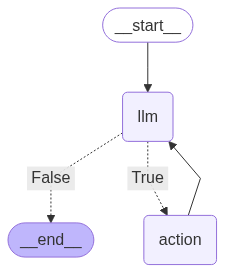

In [ ]:
from IPython.display import Image, display
display(Image(abot.graph.get_graph().draw_mermaid_png()))


In [ ]:
messages = [HumanMessage(content="i want to be tutored on fourier series.")]
result = abot.graph.invoke({"messages": messages},config={"recursion_limit": 6})

In [535]:
result

{'messages': [HumanMessage(content='i want to be tutored on fourier series.', additional_kwargs={}, response_metadata={}),
  SystemMessage(content="You are a Signals & Systems assistant that check if the topics are relevant to the course.\nWorkflow:\n1) Call tool `probe_topic` once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n2) If the SUMMARY suggests Covered , call `probe_topic` again with intent='sources'    and scope='syllabus'.\n3) Then STOP using tools. Reply briefly with:\n   - Found/Not found\n   - If found: list lecture numbers \nNever call the tool more than twice.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aDXPT4ZYwLrJRB6JfS19cBV3', 'function': {'arguments': '{"topic":"fourier series","intent":"presence"}', 'name': 'probe_topic'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 322, 'total_t

In [521]:
result['messages'][-1].content

'Found: Fourier series is covered in lectures 7, 8, and 9.'

Note that for the above, we were using the map_refine cahin type, however the deployed rag tool is using the stuff chain type

## Trying the MCP tool and optimizing the RAG class

in this approach, I optimized the built up of the above class by adding a method to load the vector db in case it is present

In [1]:
import os, sys
import openai

sys.path.append('../..')
from dotenv import load_dotenv, find_dotenv
_=load_dotenv(find_dotenv()) # read local .env file

In [5]:
from pathlib import Path
from typing import Any, Optional, Type, Annotated
import threading
from pydantic import BaseModel, Field, PrivateAttr
from langchain.tools import BaseTool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains.query_constructor.schema import AttributeInfo

class RAGSearchInput(BaseModel):
    """Input schema for the RAG search tool"""
    query: str = Field(..., description="The query to search for in the course materials")
    course_path: Optional[str] = Field(default=None, description="Path to the course materials")
    chain_type: Optional[str] = Field(default="map_reduce", description="Chain type for the QA system")

class RAGSearchTool(BaseTool):
    name: Annotated[str, Field(description="Name of the tool")] = "educated_course_material_search"
    description: Annotated[str, Field(description="Description of the tool")] = """
    Search through course materials using an educated RAG approach.
    Uses metadata filtering and conversational capabilities to provide relevant information.
    """
    args_schema: Type[BaseModel] = RAGSearchInput,
    default_course_path: Path = Field(
        default_factory=lambda: Path("../../Courses/signals and systems")
    )
    persist_directory: Path = Field(
        default_factory=lambda: Path("../docs/chroma")
    )
    collection_name: str = "course_materials"



    def __init__(
        self,
        default_course_path: Optional[Path] = None,
        persist_directory: Optional[Path] = None,
        collection_name: str = "course_materials",
    ):
        super().__init__()
        self.default_course_path = default_course_path or Path("../../Courses/signals and systems")
        self.persist_directory = Path(persist_directory or "../docs/chroma").resolve()
        self.collection_name = collection_name

        self._qa_chain = None
        self._metadata_field_info = None
        self._vectordb = None
        self._embeddings = OpenAIEmbeddings()
        self._init_lock = threading.Lock()  # guard against concurrent init

    def _load_or_build_vectordb(self):
        db_file = self.persist_directory / "chroma.sqlite3"
        if db_file.exists():
            # Fast path: just load the persisted collection
            self._vectordb = Chroma(
                persist_directory=str(self.persist_directory),
                collection_name=self.collection_name,
                embedding_function=self._embeddings,
            )
            return  

        loader = DirectoryLoader(
            str(self.default_course_path),
            glob="**/*.pdf",
            loader_cls=PyMuPDFLoader,
        )
        raw_docs = loader.load()


        splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=250)
        split_docs = splitter.split_documents(raw_docs)

        self.persist_directory.mkdir(parents=True, exist_ok=True)
        self._vectordb = Chroma.from_documents(
            documents=split_docs,
            embedding=self._embeddings,
            collection_name=self.collection_name,
            persist_directory=str(self.persist_directory),
        )

    def _initialize_components(self):
        """Initialize the RAG components if not already initialized."""
        if self._qa_chain is not None:
            return

        with self._init_lock:
            if self._qa_chain is not None:
                return  # double-checked

            # 1) Ensure vector DB exists (load if present, else build then persist)
            self._load_or_build_vectordb()

            # 2) Define metadata fields (unchanged)
            self._metadata_field_info = [
                AttributeInfo(name="category", type="string", description="Type of document: chapters | syllabus | assignments | exams"),
                AttributeInfo(name="chapter", type="integer", description="Chapter number"),
                AttributeInfo(name="lecture_number", type="integer", description="Specific lecture number"),
                AttributeInfo(name="lecture_min", type="integer", description="First lecture number in range"),
                AttributeInfo(name="lecture_max", type="integer", description="Last lecture number in range"),
                AttributeInfo(name="assignment_number", type="integer", description="Assignment number"),
                AttributeInfo(name="is_solution", type="boolean", description="Whether document is a solution"),
                AttributeInfo(name="exam_number", type="integer", description="Exam number"),
                AttributeInfo(name="term_year", type="integer", description="Academic year"),
            ]

            # 3) Create the QA chain (unchanged)
            llm = ChatOpenAI(temperature=0)
            self._qa_chain = educated_retriever(
                llm=llm,
                metadata_field_info=self._metadata_field_info,
                document_content="Course materials for Signals and Systems",
                vectordb=self._vectordb,
                chain_type="map_reduce",
            )
            
    def _run(
        self,
        query: str,
        course_path: Optional[str] = None,
        chain_type: Optional[str] = None,          # kept for compatibility; ignored unless you want to rebuild
        category: Optional[str] = None,
        chapter: Optional[int] = None,
        lecture_number: Optional[int] = None,
        k: int = 5,
    ) -> str:
        """Execute the RAG search (optionally constrained by metadata filters)."""

        # Allow switching course on the fly
        if course_path:
            self.default_course_path = Path(course_path)
            self._qa_chain = None  # Force re-init for new corpus

        # Make sure components exist
        self._initialize_components()

        # Build a HARD filter (ANDed with SQR’s inferred filter)
        # Keep it Chroma-friendly: primitives + {$lte,$gte} for ranges
        flt = {}
        if category:
            flt["category"] = category
        if chapter is not None:
            flt["chapter"] = chapter
        # If a single lecture number is requested, match exact or within [lecture_min, lecture_max]
        if lecture_number is not None:
            # Use an $or across exact number OR range gate (Chroma supports $and/$or/$lte/$gte)
            lecture_gate = {
                "$or": [
                    {"lecture_number": lecture_number},
                    {"$and": [
                        {"lecture_min": {"$lte": lecture_number}},
                        {"lecture_max": {"$gte": lecture_number}},
                    ]}
                ]
            }
            # Merge $or with any existing filter via $and (if needed)
            if flt:
                flt = {"$and": [flt, lecture_gate]}
            else:
                flt = lecture_gate

        # Stash current search kwargs, then apply ours temporarily
        retr = self._qa_chain.retriever
        orig_kwargs = dict(getattr(retr, "search_kwargs", {}) or {})
        try:
            new_kwargs = {"k": k}
            if flt:
                new_kwargs["filter"] = flt
            # Update (temporary)
            retr.search_kwargs.update(new_kwargs)

            # Run QA
            response = self._qa_chain({"question": query, "chat_history": []})

            # Format response
            answer = (response.get("answer") or "").strip()
            sources = []
            for i, doc in enumerate(response.get("source_documents", []) or [], 1):
                md = doc.metadata or {}
                parts = [f"[{i}] {md.get('category', 'unknown')}"]
                if md.get("chapter") is not None:
                    parts.append(f"Chapter {md.get('chapter')}")
                if md.get("lecture_number") is not None:
                    parts.append(f"Lecture {md.get('lecture_number')}")
                else:
                    # show range if present
                    lmin, lmax = md.get("lecture_min"), md.get("lecture_max")
                    if isinstance(lmin, int) or isinstance(lmax, int):
                        parts.append(f"Lectures {lmin}–{lmax}")
                page = md.get("page") or md.get("page_or_slide")
                if page is not None:
                    parts.append(f"p.{page}")
                parts.append(md.get("filename", "unknown file"))
                sources.append(" | ".join(parts))

            return (
                f"Answer: {answer}\n\n"
                "Sources:\n" + ("\n".join(sources) if sources else "(none)")
            )

        except Exception as e:
            return f"Error: {e!r}"
        finally:
            # Always restore retriever kwargs so filters don't leak across tool calls
            retr.search_kwargs.clear()
            retr.search_kwargs.update(orig_kwargs)



In [6]:
rag_tool =  RAGSearchTool(
    default_course_path=Path("../../Courses/signals and systems"),
    persist_directory=Path("../../Rag/docs/chroma"),
    collection_name="ele430_signals",
)

In [7]:
from typing import Literal, Dict, Any, List, Optional
from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool
import json, re

class ProbeArgs(BaseModel):
    topic: str
    intent: Literal["presence", "material", "exercises", "tests", "resources"] = "presence"
    lectures: Optional[List[int]] = Field(default=None, description="Lecture hints; for material we may use the first.")
    k: int = Field(default=15, ge=1, le=50)


class ListingsOut(BaseModel):
    text: str = Field(..., description="Up to k terse lines; agent can display as sources.")


def _probe_topic_fn(topic: str,
                    intent: str = "presence",
                    lectures: Optional[List[int]] = None,
                    k: int = 15) -> Dict[str, Any]:

    # ---- PRESENCE (syllabus only) ----
    if intent == "presence":
        prompt = f"""
        
You are checking the syllabus for: "{topic}".
if the topic is mentioned in the syllabus, it is covered, else it is not covered.
Respond with STRICT JSON ONLY:
{{
  "covered": <true|false>,
  "note": "<=120 chars brief reason or closest phrasing>"
}}

(No sources, no extra keys.)
""".strip()
        text = str(rag_tool._run(query=prompt, category="syllabus", k=5))
        return {"text": text}

    # ---- RESOURCES (lectures from syllabus) ----
# inside _probe_topic_fn(...)

    if intent == "resources":
        # Syllabus-only; agent will parse this tiny, regular format.
        prompt = f"""
    based on the syllabus, which lectures discuss "{topic}".

    OUTPUT EXACTLY TWO LINES (no extra text, no quotes, no sources):
    LECTURES: <comma-separated lecture numbers as written in the syllabus
    NOTE: <<=120 chars brief reason or closest phrasing>
    """.strip()

        text = str(rag_tool._run(query=prompt, category="syllabus", k=5))
        return {"text": text}


    scope_by_intent = {
        "material": "chapters",
        "exercises": "assignments",
        "tests": "exams",
    }
    scope = scope_by_intent[intent]
    lec = None
    if lectures and len(lectures) > 0:
        try: lec = int(lectures[0])
        except: lec = None

    header = f"TOPIC: {topic}\nSCOPE: {scope.upper()}\nFORMAT: Up to {k} terse lines.\n" \
             f"Each line: - Lecture=<N or ?> | Chapter=<N or ?> | <filename> | page=<n> | relpath=<p> | snippet: <≤120 chars>"
    guide = "If a lecture hint is provided, prefer that lecture; otherwise choose best matches."
    prompt = f"{header}\n{guide}"

    text = rag_tool._run(query=prompt, category=scope, lecture_number=lec, k=k)
    return ListingsOut(text=str(text)).model_dump()

probe_topic = StructuredTool.from_function(
    name="probe_topic",
    description=("Educated probe over course corpora.\n"
                 "Intents:\n"
                 "- presence  : syllabus-only coverage, {covered, note} (no sources)\n"
                 "- resources : syllabus-only lecture mapping, {covered, lectures[], note} (no sources)\n"
                 "- material  : chapters-only listings (up to k lines)\n"
                 "- exercises : assignments-only listings (up to k lines)\n"
                 "- tests     : exams-only listings (up to k lines)"),
    func=_probe_topic_fn,
    args_schema=ProbeArgs,
)


In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI


In [4]:
from mcp import ClientSession
from mcp.client.sse import sse_client
from langchain_mcp_adapters.tools import load_mcp_tools

sse_cm = sse_client("http://127.0.0.1:8787/sse")
read_stream, write_stream = await sse_cm.__aenter__()
session_cm = ClientSession(read_stream, write_stream)
session = await session_cm.__aenter__()
await session.initialize()

# load MCP tools in to langchain Structured tools
tools = await load_mcp_tools(session=session)
tool_map = {tool.name: tool for tool in tools}
tool_map

{'probe_topic': StructuredTool(name='probe_topic', description='Educated probe over course corpora. Intents: presence (syllabus), resources (syllabus), material (chapters), exercises (assignments), tests (exams).', args_schema={'properties': {'topic': {'title': 'Topic', 'type': 'string'}, 'intent': {'default': 'presence', 'enum': ['presence', 'material', 'exercises', 'tests', 'resources'], 'title': 'Intent', 'type': 'string'}, 'lectures': {'anyOf': [{'items': {'type': 'integer'}, 'type': 'array'}, {'type': 'null'}], 'default': None, 'title': 'Lectures'}, 'k': {'default': 15, 'title': 'K', 'type': 'integer'}}, 'required': ['topic'], 'title': 'mcp_probe_topicArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000019A477120C0>),
 'draf_email': StructuredTool(name='draf_email', description="\n        Creates a draft email in the user's Gmail account.\n        Requires the recipient's email ad

In [5]:
# TOOLS=[probe_topic]
TOOLS=[tool_map['probe_topic']] # trying the server after trying the enhanced rag class

In [10]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [11]:
from typing import Annotated, TypedDict
import operator, json
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage, HumanMessage, AIMessage
import asyncio

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:
    def __init__(self, model, tools, system: str = "" ,debug: bool = True):
        # normalize tools if someone passed [TOOLS]
        if len(tools) == 1 and isinstance(tools[0], (list, tuple)):
            tools = list(tools[0])

        self.debug = debug
        self.system = system.strip()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self._system_injected = False
        self.messages_key = "messages"
        
        g = StateGraph(AgentState)
        g.add_node("llm", self.call_openai)
        g.add_node("action", self.take_action)
        g.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        g.add_edge("action", "llm")
        g.set_entry_point("llm")
        self.graph = g.compile()

    def _get_msgs(self, state):
        return state.get(self.messages_key, [])

    def _set_msgs(self, state, new_msgs):
        return {self.messages_key: new_msgs}

    # ---------- helpers
    def _show_msg(self, m):
        if isinstance(m, HumanMessage):
            return f"Human: {m.content}"
        if isinstance(m, SystemMessage):
            return f"System: {m.content[:180]}{'…' if len(m.content)>180 else ''}"
        if isinstance(m, AIMessage):
            calls = getattr(m, "tool_calls", None)
            return f"AI: {m.content[:180]}{'…' if len(m.content)>180 else ''} | tool_calls={calls}"
        if isinstance(m, ToolMessage):
            body = str(m.content)
            return f"ToolResult[{m.name}]: {body[:220]}{'…' if len(body)>220 else ''}"
        return f"{type(m).__name__}"

    def exists_action(self, state: AgentState):
        last = state["messages"][-1]
        want_tools = isinstance(last, AIMessage) and bool(getattr(last, "tool_calls", None))
        return want_tools
    
    async def call_openai(self, state: AgentState):
        msgs = state["messages"]

        to_add = []
        # inject system once (delta)
        if self.system and not self._system_injected:
            to_add.append(SystemMessage(content=self.system))
            self._system_injected = True

        model_input = msgs + to_add

        if self.debug:
            print("\n[call_openai] ---- MESSAGES TO LLM ----")
            for m in model_input:
                print(" ", self._show_msg(m))

        ai = await self.model.ainvoke(model_input)


        # IMPORTANT: return **only** the delta so the reducer appends it
        return {"messages": to_add + [ai]}



    async def take_action(self, state: AgentState):
        last = state["messages"][-1]
        tool_calls = (getattr(last, "tool_calls", None) or [])[:1]

        results = []
        for tc in tool_calls:
            name, args, tid = tc["name"], tc.get("args", {}), tc["id"]
            tool = self.tools.get(name)
            if not tool:
                result = "bad tool name, retry"
            else:
                # support both Runnable tools and core spec tools
                if hasattr(tool, "ainvoke"):
                    result = await tool.ainvoke(args)
                elif hasattr(tool, "invoke"):
                    import asyncio
                    result = await asyncio.to_thread(tool.invoke, args)
                else:
                    # langchain_core.tools.StructuredTool (spec) -> use .func
                    result = await asyncio.to_thread(tool.func, **(args or {}))

            tm = ToolMessage(tool_call_id=tid, name=name, content=str(result))
            results.append(tm)

        print("[take_action] Back to model")
        # ONLY append the tool results (delta)
        return {"messages": results}

## SubGraph 1: Relevance Checker with the RAG MCP tool

The above examples where tests, thats why i asked chatgpt to introduce a debugging mechanism, note that i did check that the functionalities where the same and note changed, now we want to build our own subgraphs, thats why i will return to the original method for that purpose.

In [12]:
import asyncio
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        want_tools = isinstance(result, AIMessage) and bool(getattr(result, "tool_calls", None))
        return  want_tools

    async def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = await self.model.ainvoke(messages) # aynchronous invoke
        return {'messages': [message]}

    async def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                 result = await self.tools[t['name']].ainvoke(t['args']) # aynchronous invoke
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

To make the above method compatible with the mcp tool, i added the aync and await keywords. Note that you also need to use ainvoke (took me 1 hour to fix the errors related to it)

In [7]:
relevancer={}

#### Prompts

For the sake of documentation, i decided to add my prompts and their adjustments. note that to reach prompt 1, it took me many trials but did not think of documenting them.

In [32]:
# did not add an output schema for the model to follow
prompt_1=(
"""
"You are a Signals & Systems assistant that check if the topic present in the user query is relevant to the course.\n"
    "Workflow:\n"
    "1) Call tool probe_topic once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n"
    "2) If the summary suggests Covered , call probe_topic again with intent='resources' "
    "   and scope='syllabus'.\n"
    "3) Then STOP using tools. Reply briefly with:\n"
    "   - topic: string stating what was the topic the user was asking about\n"
    "   - is_relevant: boolean that is set to true if the topic is found\n"
    "   - If found: list lecture numbers in a list called list \n"
    "Never call the tool more than twice."
""")

In [33]:
# forget to state the purpose of the intent param
prompt_2 = (
    "You are a Signals & Systems assistant that check if the topic present in the user query is relevant to the course.\n"
    "Workflow:\n"
    "1) Call tool probe_topic once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n"
    "2) If the summary suggests Covered , call probe_topic again with intent='resources' "
    "   and scope='syllabus'.\n"
    "3) Then STOP using tools. Reply briefly with:\n"
    "   - topic: string stating what was the topic the user was asking about\n"
    "   - is_relevant: boolean that is set to true if the topic is found\n"
    "   - If found: list lecture numbers in a list called list \n"
    "Never call the tool more than twice.\n"
    """ Return ONE valid JSON object ONLY, no prose.
        Required JSON shape:
        {
        "intent": string,              // natural question or tutoring request
        "topic": string,               // the topic the user is asking about
        "is_relevant": boolean,        // true iff the topic is found
        "list": number[]               // lecture numbers where the topic appears; [] if none/not found
        }
    """)

In [34]:
prompt_3 = (
    "You are a Signals & Systems assistant that check if the topic present in the user query is relevant to the course.\n"
    "Workflow:\n"
    "1) Call tool probe_topic once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n"
    "2) If the summary suggests Covered , call probe_topic again with intent='resources' "
    "   and scope='syllabus'.\n"
    "3) Then STOP using tools. Reply briefly with:\n"
    "   - topic: string stating what was the topic the user was asking about\n"
    "   - is_relevant: boolean that is set to true if the topic is found\n"
    "   - If found: list lecture numbers in a list called list \n"
    "   - intent: the purpose of the user query, (to be tutored or to ask a question)"
    "Never call the tool more than twice.\n"
    """ Return ONE valid JSON object ONLY, no prose.
        Required JSON shape:
        {
        "intent": string,              // natural question or tutoring request
        "topic": string,               // the topic the user is asking about
        "is_relevant": boolean,        // true iff the topic is found
        "list": number[]               // lecture numbers where the topic appears; [] if none/not found
        }
    """
)

### the Relevancer Graph

for the final prompt, i have changed the name of the intent keyword that is expected to be return to purpose so that the model is not confused with the intent output key and the intent tool key that is to be configured in the agentic rag tool.

In [8]:
TOOLS=[tool_map['probe_topic']] # trying the server after trying the enhanced rag class
prompt = (
    "You are a Signals & Systems assistant that check if the topic present in the user query is relevant to the course.\n"
    "Workflow:\n"
    "1) Call tool probe_topic once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n"
    "2) If the summary suggests Covered , call probe_topic again with intent='resources' "
    "   and scope='syllabus'.\n"
    "3) Then STOP using tools. Reply briefly with:\n"
    "   - topic: string stating what was the topic the user was asking about\n"
    "   - is_relevant: boolean that is set to true if the topic is found\n"
    "   - If found: list lecture numbers in a list called list\n"
    "   - purpose: string representing the user purpose, can be either one of two, either \"tutoring\" or \"general question\", depending on the query\n"
    "Never call the tool more than twice.\n"
    """ Return ONE valid JSON object ONLY, no prose.
        Required JSON shape:
        {
        "purpose": string,              // natural question or tutoring request
        "topic": string,               // the topic the user is asking about
        "is_relevant": boolean,        // true iff the topic is found
        "list": number[]               // lecture numbers where the topic appears; [] if none/not found
        }
    """
).strip()

model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
referncer_agent = Agent(model, TOOLS, system=prompt)

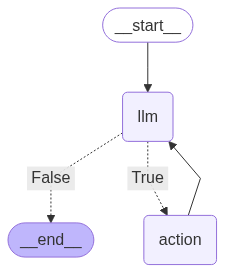

In [ ]:
from IPython.display import Image, display
display(Image(referncer_agent.graph.get_graph().draw_mermaid_png()))


In [6]:
from typing import Any, Dict,List

from langchain_core.messages import HumanMessage

async def run_single_graph_test(graph, query: str):
    payload = {"messages": [HumanMessage(content=query)]}
    print(f"--- Invoking graph with query: '{query}'")
    out = await graph.ainvoke(payload)
    print(f"--- Graph invocation complete.")
    return out

In [ ]:
# messages = [HumanMessage(content="i want to be tutored on fourier series.")]
# result = abot.graph.invoke({"messages": messages},config={"recursion_limit": 6})
response = await run_single_graph_test(abot.graph, "i want to be tutored on fourier series.")

NameError: name 'run_single_graph_test' is not defined

In [56]:
print(response['messages'][-1].content)

{
  "purpose": "tutoring",
  "topic": "fourier series",
  "is_relevant": true,
  "list": [5, 6, 7]
}


In [61]:
type(response)

dict

In [57]:
type(response['messages'][-1].content)

str

In [7]:
import json

In [59]:
res=json.loads(response['messages'][-1].content)

In [60]:
type(res), res

(dict,
 {'purpose': 'tutoring',
  'topic': 'fourier series',
  'is_relevant': True,
  'list': [5, 6, 7]})

In [79]:
type(res['list']), type(res['list'][0])

(list, int)

In [13]:
class RelevancerStateModel(AgentState):
    purpose: str
    topic: str
    is_relevant: bool
    lectures: List[int]

In [18]:
def referencer_output(state: AgentState):
    res=json.loads(state['messages'][-1].content)
    purpose= res['purpose']
    topic= res['topic']
    is_relevant =res['is_relevant']
    lectures= res['lecture_list']

### Sub Graph 1, the Relevancer

In [15]:
from langgraph.graph import StateGraph, START, END
relevancer_builder = StateGraph(AgentState,output_schema=RelevancerStateModel)
relevancer_builder.add_node("check_relevance", referncer_agent.graph)
relevancer_builder.add_node("output_state",referencer_output )
relevancer_builder.add_edge(START, "check_relevance")
relevancer_builder.add_edge("check_relevance", "output_state")
relevancer_builder.add_edge("output_state", END)

In [87]:
response = await run_single_graph_test(relevancer_builder.compile(), "i want to be tutored on fourier series.")

--- Invoking graph with query: 'i want to be tutored on fourier series.'
Calling: {'name': 'probe_topic', 'args': {'topic': 'fourier series', 'intent': 'presence', 'scope': 'syllabus'}, 'id': 'call_h8fMeMbpcGO9fHIizqu7l1eu', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'probe_topic', 'args': {'topic': 'fourier series', 'intent': 'resources', 'scope': 'syllabus'}, 'id': 'call_RYBgBCTsEogHef0W4tUIbR0f', 'type': 'tool_call'}
Back to the model!
--- Graph invocation complete.


**note:** even though i am not mentioning every detail of the error debugging process since many errors are solved instantly by refering to the documentation, i want to note the following, when i intended to wrap my outputs in the output schema model.

I followed the following approach:

```
def referencer_output(state: AgentState):
    response=state.get("messages")
    res=json.loads(response['messages'][-1].content)
    purpose= res['purose']
    topic= res['topic']
    is_relevant =res['is_relevant']
    lectures= res['list']
```

i got the following error:list indices must be integers or slices, not str. That is because the resposne below is the state it self, the silliest mistake ever that shows you the importance of the documentation. to fix the error, just remover the first line in the method :)




#### irrelvant question tryout

In [88]:
response = await run_single_graph_test(relevancer_builder.compile(), "hi, how are you")

--- Invoking graph with query: 'hi, how are you'
--- Graph invocation complete.


In [89]:
response['messages'][-1].content

'{\n  "purpose": "general question",\n  "topic": "",\n  "is_relevant": false,\n  "list": []\n}'

In [20]:
response = await run_single_graph_test(relevancer_builder, "i want to be tutored on z-transform")

--- Invoking graph with query: 'i want to be tutored on z-transform'
Calling: {'name': 'probe_topic', 'args': {'topic': 'Z-transform', 'intent': 'presence', 'scope': 'syllabus'}, 'id': 'call_ra0b1kDIO62OaxdMTGy40VzY', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'probe_topic', 'args': {'topic': 'Z-transform', 'intent': 'resources', 'scope': 'syllabus'}, 'id': 'call_vIgOicfRSWLRKRwpFEG3OKEN', 'type': 'tool_call'}
Back to the model!
--- Graph invocation complete.


In [21]:
print(response['messages'][-1].content)

{
  "message": "Great! We can certainly focus on Z-transform in your tutoring sessions. It's covered in multiple lectures.",
  "purpose": "plan_session",
  "topic": "Z-transform",
  "is_relevant": true,
  "lecture_list": [2, 5],
  "tool_calls_issued": 2
}


#####################

In [131]:
response = await run_single_graph_test(referncer_agent.graph, "hi, who is the lebanese president")
response['messages'][-1].content

--- Invoking graph with query: 'hi, who is the lebanese president'
--- Graph invocation complete.


'{\n  "message": "I am only a signal and systems assistant.",\n  "purpose": "out of context",\n  "topic": "greeting",\n  "is_relevant": false,\n  "list": []\n}'

In [132]:
type(response['messages'][-1].content)

str

In [134]:
print(response)

{'messages': [HumanMessage(content='hi, who is the lebanese president', additional_kwargs={}, response_metadata={}), AIMessage(content='{\n  "message": "I am only a signal and systems assistant.",\n  "purpose": "out of context",\n  "topic": "greeting",\n  "is_relevant": false,\n  "list": []\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 547, 'total_tokens': 594, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C6GviYNrLPU6ks2LtAcZWspZq6kOa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ee7e1f1c-dcce-4398-8ae1-ea5f37b0dc49-0', usage_metadata={'input_tokens': 547, 'output_tokens': 47, 'total_tokens': 594, 'input_token_details': {'audio

### Further Prompt Finetunnig, to the next level

Now, i will introduce memory to my relevancer and increase the keys of the relevancer state.

In [56]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [57]:
# db_path = '../db/checkpoints.db'
# conn = sqlite3.connect(db_path, check_same_thread=False) # we can use multiple threads
# print(conn)
# memory = SqliteSaver(conn)


# from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
# db_path = '../db/checkpoints.db'
# conn = sqlite3.connect(db_path, check_same_thread=False) # we can use multiple threads
# print(conn)
# memory = AsyncSqliteSaver(conn)

In [41]:
# # short term memory
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [42]:
from langgraph.graph.message import add_messages
import asyncio
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
class Agent:

    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            # interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        want_tools = isinstance(result, AIMessage) and bool(getattr(result, "tool_calls", None))
        return  want_tools

    async def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = await self.model.ainvoke(messages) # aynchronous invoke
        return {'messages': [message]}

    async def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                 result = await self.tools[t['name']].ainvoke(t['args']) # aynchronous invoke
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [ ]:
TOOLS=[tool_map['probe_topic']] # trying the server after trying the enhanced rag class
prompt = (
    "You are a Signals & Systems tutoring assistant that check if the topic present in the user query is relevant to the course.\n"
    "If the user is greeting you, greet him back and ask him how could you help him, set the topic to greeting, irrelevant to true, and the purpose to out of context\n"
    "If the question is irrelevant to the signals and systems engineering topic, respond to the user by stating that you are only a signal and systems assistant. \n"
    "In case the question was relevant to the signals and systems engineering topic, follow the following workflow. \n"
    "If the query is relevant to the Signals and Systems course (i.e., \"is_relevant\": true and \"purpose\" is \"tutoring\" or \"topic general question\"), you MUST ask the user for their email address so you can draft the study plan/resources and a meeting link for the tutor to send. Put this ask in the \"email\" field. If the user already provided an email in the same turn, acknowledge it and do not ask again.\n"
    "Workflow:\n"
    "1) Call tool probe_topic once with intent='presence' and scope='syllabus'. The topic must be extracted from the user\n"
    "2) If the summary suggests Covered , call probe_topic again with intent='resources' "
    "   and scope='syllabus'.\n"
    "3) Then STOP using tools. Reply briefly with:\n"
    "   - topic: string stating what was the topic the user was asking about\n"
    "   - is_relevant: boolean that is set to true if the topic is found\n"
    "   - If found: list lecture numbers in a list called list\n"
    "   - purpose: string representing the user purpose, can be either one of three, either \"tutoring\" or \"topic general question\" or \"out of context\", depending on the query. note that every question outside the scope of the signal and systems engineering topic is considered \"out of context\", not \"general question\". \"general question\" catergory represent the questions related to the signals and systems topic.\n"
    "   - message: one short sentence. If is_relevant is true AND purpose ∈ {\"tutoring\",\"topic general question\"}, ask for the user's email to send the plan/resources and a meeting link (e.g., \"What’s your email so that I may draft the tutoring session plan to be sent by the tutor with the metting link?\"). Otherwise do NOT ask for email.\n"
    "   - email: string; the user's email if they provided one in this turn; otherwise "" (empty string). Lowercase and trim whitespace."
        "Never call the tool more than twice.\n"
    """ Return ONE valid JSON object ONLY, no prose.
        Required JSON shape:
        {
        "message": string,              // your response to the user query
        "purpose": string,              // natural question or tutoring request
        "topic": string,               // the topic the user is asking about
        "is_relevant": boolean,        // true iff the topic is found
        "list": number[]               // lecture numbers where the topic appears; [] if none/not found
        "email": string             // user's email if provided; otherwise ""
        }
        Include ALL keys exactly as named: "message", "purpose", "topic", "is_relevant", "list", "email". Do not add extra keys. Do not guess an email; if none was given, set "email": "".
        When extracting an email, only accept strings that contain exactly one "@" and at least one "." after it. If invalid, set "email": "" and ask again in "message".
    """
).strip()


In [10]:
class RelevancerStateModel(AgentState):
    purpose: str
    topic: str
    is_relevant: bool
    lectures: List[int]
def referencer_output(state: AgentState):
    res=json.loads(state['messages'][-1].content)
    purpose= res['purpose']  # not critical
    topic= res['topic']
    is_relevant =res['is_relevant']
    lectures= res['list']
    return {
        
    }


In [11]:
model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
referncer_agent = Agent(model, TOOLS, system=prompt, )

from langgraph.graph import StateGraph, START, END
relevancer_builder = StateGraph(AgentState,output_schema=RelevancerStateModel)
relevancer_builder.add_node("check_relevance", referncer_agent.graph)
relevancer_builder.add_node("output_state",referencer_output )
relevancer_builder.add_edge(START, "check_relevance")
relevancer_builder.add_edge("check_relevance", "output_state")
relevancer_builder.add_edge("output_state", END)
relevancer_builder=relevancer_builder.compile()

In [71]:
messages = [HumanMessage(content="hello")]
thread = {"configurable": {"thread_id": "1"}}
# for event in referncer_agent.graph.astream({"messages": messages}, thread):
#     for v in event.values():
#         print(v)
result = await referncer_agent.graph.ainvoke({"messages": messages}, thread)


In [74]:
result['messages'][-1].content

'{\n  "message": "Hello! How can I help you today?",\n  "purpose": "out of context",\n  "topic": "greeting",\n  "is_relevant": true,\n  "list": [],\n  "email": ""\n}'

In [75]:
result = await referncer_agent.graph.ainvoke({"messages": "i want to be tutored on fourier transform"}, thread)


Calling: {'name': 'probe_topic', 'args': {'topic': 'fourier transform', 'intent': 'presence', 'scope': 'syllabus'}, 'id': 'call_fKHaGdj7a5M2a7B2ewfLrQWb', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'probe_topic', 'args': {'topic': 'fourier transform', 'intent': 'resources', 'scope': 'syllabus'}, 'id': 'call_uFE0z462oa0nHZLM1QBF9n48', 'type': 'tool_call'}
Back to the model!


In [76]:
result['messages'][-1].content

'{\n  "message": "The topic \'Fourier Transform\' is covered in lectures 5, 6, 7, and 8. What’s your email so I can send the plan and a meeting link?",\n  "purpose": "tutoring",\n  "topic": "fourier transform",\n  "is_relevant": true,\n  "list": [5, 6, 7, 8],\n  "email": ""\n}'

In [77]:
result = await referncer_agent.graph.ainvoke({"messages": "ali yassine"}, thread)
result['messages'][-1].content

'{\n  "message": "Please provide a valid email address that contains an \'@\' and a \'.\' so I can send the plan and a meeting link.",\n  "purpose": "tutoring",\n  "topic": "fourier transform",\n  "is_relevant": true,\n  "list": [5, 6, 7, 8],\n  "email": ""\n}'

In [78]:
result = await referncer_agent.graph.ainvoke({"messages": "ay8151863@gmail.com"}, thread)
result['messages'][-1].content

'{\n  "message": "Great! I\'ll send you the study plan and a meeting link at ay8151863@gmail.com.",\n  "purpose": "tutoring",\n  "topic": "fourier transform",\n  "is_relevant": true,\n  "list": [5, 6, 7, 8],\n  "email": "ay8151863@gmail.com"\n}'

### trying with the sub graph as whole

#### test 1

In [85]:
result = await relevancer_builder.ainvoke({"messages": "i want to be tutored on fourier transform, this is my email: ay8151863@gmail.com"}, thread)

Calling: {'name': 'probe_topic', 'args': {'topic': 'fourier transform', 'intent': 'presence', 'scope': 'syllabus'}, 'id': 'call_aSplKBbtIzAzbzpH0BjbXNSX', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'probe_topic', 'args': {'topic': 'fourier transform', 'intent': 'resources', 'scope': 'syllabus'}, 'id': 'call_EvnE7oAwjwIXvBXiGVLfMAZD', 'type': 'tool_call'}
Back to the model!


#### test 2

while working on the above snippet, got the following error:  '_GeneratorContextManager' object has no attribute 'get_next_version'. 

to fix it: i refered to the following ref: https://community.deeplearning.ai/t/lesson-4-persistence-and-streaming-attributeerror-generatorcontextmanager-object-has-no-attribute-get-next-version/697391

## Session Planner with the MCP tool

checking the efficiency of our previously builted prompt in action

In [50]:
TOOLS=[tool_map['probe_topic']] # trying the server after trying the enhanced rag class
prompt = r"""
You are a Signals & Systems tutoring planner.

### GOAL
- Given a user topic (and optional lecture hints or duration hints), retrieve the relevant lecture material and output a compact tutoring plan as JSON ("SessionPlan").

### TOOL USE (exactly one call)
- Call tool probe_topic *once* with:
  - intent="material"
  - topic=<extracted topic>
  - scope is handled internally by the tool (maps "material" → "chapters"); do *not* set it yourself.
  - If the user explicitly mentions specific lectures (e.g., "only lecture 1", "lectures 2-3"), pass lectures=[<numbers>].
  - You may leave k at its default unless the user requests otherwise.
- Do *not* call any other intent. Do *not* call tools more than once.

### WHAT THE TOOL RETURNS (read-only evidence)
- The tool returns an object with a "text" field (string).
- The "text" consists of up to k terse lines, each line following:
  Lecture=<N or ?> | Chapter=<N or ?> | <filename> | page=<n> | relpath=<p> | snippet: <≤120 chars>
- Use *only* this "text" content as evidence for concepts and references. Do *not* invent information not present in it.

### PLANNING RULES (strict; no hallucinations)
- Extract key teaching points **from the snippet parts** and file/section cues in the listings.
- *Duration:*
  - Default is *"45 minutes per lecture"* included (returned by tool or explicitly hinted by the user).
  - If the user specifies a *per-lecture duration* (e.g., "60 minutes per lecture"), use that instead of 45.
  - If the user specifies a *total duration* (e.g., "90 minutes total"), divide evenly across the included lectures and adjust agenda blocks so totals match.
- *Agenda construction:*
  - The "Agenda" must cover the *full* computed "Duration".
  - Use contiguous minute ranges (e.g., "0-5", "5-15", "15-30", ...), with 4–6 blocks total.
  - For 45 minutes per lecture, a good default is:
    - "0-5" (orientation),
    - "5-15" (core concepts),
    - "15-30" (worked example),
    - "30-45" (guided practice & recap).
  - If duration differs, proportionally adapt the block lengths; ensure no gaps or overlaps.
- *Multiple lectures:*
  - Aggregate materials across the selected lectures into *one* coherent SessionPlan.
  - "Objectives" and "Key Concepts (from materials)" should reflect the union of covered points (deduplicate; keep ~3–6 bullets each).
  - "References (lectures)" must reflect the tool output. Prefer the original listing lines, or derive a clear line that preserves *Lecture/Chapter/filename/page*. Sort by lecture number when numeric.
- *User lecture hints vs. tool results:*
  - If the user says "only lecture X", restrict to X even if the tool mentions others.

### EDGE CASES
- If the tool’s "text" is empty or contains no usable lines, output a minimal placeholder plan:
  - "Duration": "0 minutes"
  - Empty arrays for "Objectives", "Key Concepts (from materials)", "Agenda", "Active Practice", "References (lectures)"
  - "Title" should still be the topic.

### OUTPUT CONTRACT (one JSON object only; no prose)
Respond *only* with a valid JSON object using these exact keys (strings). No extra keys, no explanations.

{
  "Title": "<topic>",
  "Duration": "<N> minutes",
  "Objectives": [
    "<bullet>",
    "<bullet>"
  ],
  "Key Concepts (from materials)": [
    "<bullet>",
    "<bullet>"
  ],
  "Agenda": [
    "0-5: <bullet>",
    "5-15: <bullet>",
    "15-30: <bullet>",
    "30-45: <bullet>"
  ],
  "Active Practice": [
    "<bullet>",
    "<bullet>"
  ],
  "References (lectures)": [
    "<lecture ref from tool output>",
    "<lecture ref from tool output>"
  ]
}

### VALIDATION CHECKS BEFORE YOU ANSWER
- Keys are *exactly* as above.
- The "Duration" string equals the total minutes implied by the "Agenda".
- "Agenda" blocks are contiguous, strictly increasing, and fully cover the "Duration".
- All "Key Concepts" and "References (lectures)" are supported by the tool’s "text".
- You made *exactly one* probe_topic call with intent="material".
""".strip()

model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
planner_agent = Agent(model, TOOLS, system=prompt)

In [51]:
query="""
{
  "message": "Great! The Z transform is covered in your syllabus. Would you like me to help explain the concept or work on some exercises?",
  "purpose": "explain_concept",
  "topic": "Z transform",
  "is_relevant": true,
  "lecture_list": [2, 7],
  "tool_calls_issued": 2
}
"""

In [52]:
response = await run_single_graph_test(planner_agent.graph, query)
response['messages'][-1].content

--- Invoking graph with query: '
{
  "message": "Great! The Z transform is covered in your syllabus. Would you like me to help explain the concept or work on some exercises?",
  "purpose": "explain_concept",
  "topic": "Z transform",
  "is_relevant": true,
  "lecture_list": [2, 7],
  "tool_calls_issued": 2
}
'

[call_openai] ---- MESSAGES TO LLM ----
  Human: 
{
  "message": "Great! The Z transform is covered in your syllabus. Would you like me to help explain the concept or work on some exercises?",
  "purpose": "explain_concept",
  "topic": "Z transform",
  "is_relevant": true,
  "lecture_list": [2, 7],
  "tool_calls_issued": 2
}

  System: You are a Signals & Systems tutoring planner.

### GOAL
- Given a user topic (and optional lecture hints or duration hints), retrieve the relevant lecture material and output a com…
[take_action] Back to model

[call_openai] ---- MESSAGES TO LLM ----
  Human: 
{
  "message": "Great! The Z transform is covered in your syllabus. Would you like me to

'{\n  "Title": "Z transform",\n  "Duration": "0 minutes",\n  "Objectives": [],\n  "Key Concepts (from materials)": [],\n  "Agenda": [],\n  "Active Practice": [],\n  "References (lectures)": []\n}'

In [53]:
print(response['messages'][-1].content)

{
  "Title": "Z transform",
  "Duration": "0 minutes",
  "Objectives": [],
  "Key Concepts (from materials)": [],
  "Agenda": [],
  "Active Practice": [],
  "References (lectures)": []
}


In [106]:
type(response['messages'][-1].content)

str

In [31]:
class PlannerStateModel(AgentState):
    plan: str
def planner_output(state: AgentState):
    res=json.loads(state['messages'][-1].content)
    plan= res['plan']  # not critical
    return {"answer": plan}


In [32]:
from langgraph.graph import StateGraph, START, END
planner_builder = StateGraph(AgentState,output_schema=PlannerStateModel)
planner_builder.add_node("planner", planner_agent.graph)
planner_builder.add_node("planner_state",planner_output )
planner_builder.add_edge(START, "planner")
planner_builder.add_edge("planner", "planner_state")
planner_builder.add_edge("planner_state", END)
planner_builder=planner_builder.compile()

### Creating the Complete Graph

In [18]:
class TutorStateModel(AgentState):
    purpose: str
    topic: str
    email: str
    plan: str

In [19]:

from langgraph.prebuilt import tools_condition
def relevance_router(state: RelevancerStateModel):
    res=json.loads(state['messages'][-1].content)
    if(res['is_relevant']==False):
        return "end"
    else: 
        return "planner"
    
entry_builder = StateGraph(TutorStateModel)
entry_builder.add_node("relevancer", relevancer_builder)
entry_builder.add_node("planning_session", planner_builder)

entry_builder.add_edge(START,"relevancer")

entry_builder.add_conditional_edges(
    "relevancer", # must be the name of the routing node
    relevance_router,
    {"planner": "planning_session", "end": END},
)
entry_builder.add_edge("planning_session", END)
graph = entry_builder.compile()

Had some trouble with the conditional edge, lesson learned: do not create a node for the conditional edge funciton, took me 30 mins scrolling in the documentation.

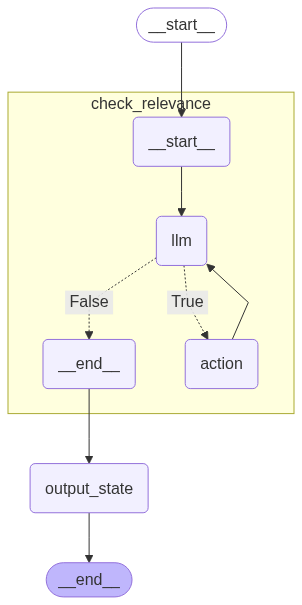

In [20]:
from IPython.display import Image, display
display(Image(relevancer_builder.get_graph(xray=True).draw_mermaid_png()))

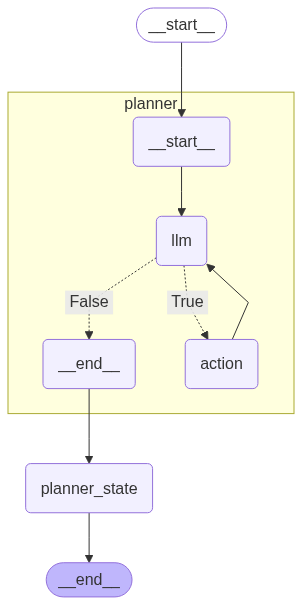

In [21]:
from IPython.display import Image, display
display(Image(planner_builder.get_graph(xray=True).draw_mermaid_png()))

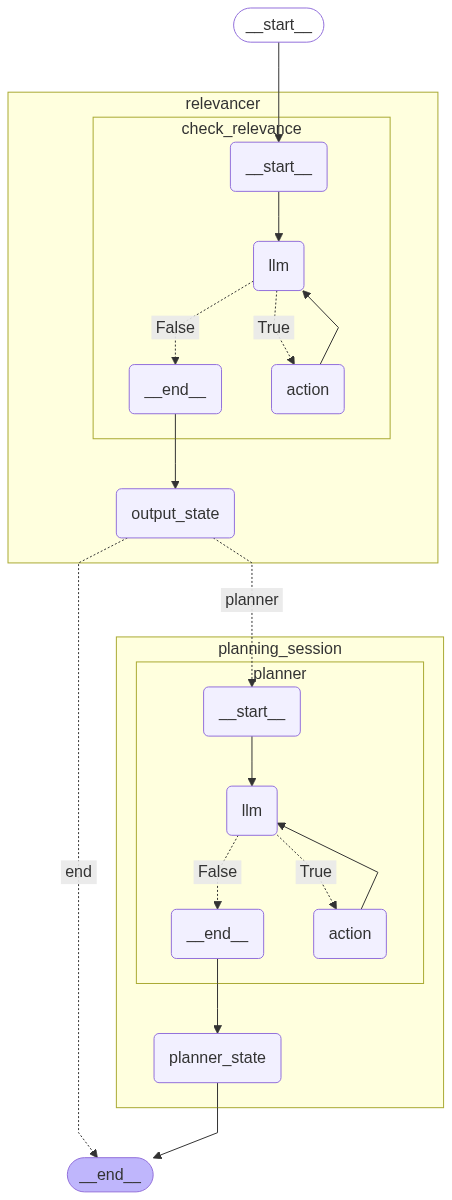

In [22]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [23]:
response = await run_single_graph_test(graph, "i want to be tutored on fourier series")

--- Invoking graph with query: 'i want to be tutored on fourier series'


NameError: name 'AIMessage' is not defined

In [203]:
print(response['messages'][-1].content)

{
  "plan": {
    "Title": "Fourier Series",
    "Duration": 135,
    "Objectives": [
      "Understand the concept and mathematical formulation of Fourier series.",
      "Learn how to calculate Fourier coefficients and represent functions as Fourier series."
    ],
    "Key Concepts (from materials)": [
      "Periodic functions and their representation using sine and cosine series.",
      "Convergence of Fourier series and applications in signal processing."
    ],
    "Agenda": [
      "0–5: Introduction to Fourier series and key terms.",
      "5–15: Discussion of periodic functions and their representations.",
      "15–30: Derivation of Fourier coefficients.",
      "30–45: Representation of functions as Fourier series.",
      "45–60: Introduce convergence of Fourier series.",
      "60–75: Applications of Fourier series in engineering and physics.",
      "75–90: Working examples and problem-solving.",
      "90–105: Summary and key takeaways.",
      "105–135: Active practic

## Concepts Assistant with MCP

In [24]:
prompt_1=(
"""
You are a Signals & Systems Course Exercise Generator.

Goal:
- Given a user topic, retrieve relevant lecture material and output a structured answer.

Tool use :
- Call tool `probe_topic`  with intent="material".
- If the user hints specific lectures (e.g., "only lecture 1" / "lectures 2-3"), pass lectures=[...] to the tool.
- In case of multiple lectures hinted, you should search for the answer in each lecture.
- Do not call any other intents. Do not call tools more than once.

How to plan:
- Read ONLY the tool’s returned text (listings) as your evidence.
- Derive key teaching points present in the sources (don’t invent).
- Build a 45 minute plan for every lecture, by default unless the user specifies duration.
- In case of multiple lectures, overall plan duration is equal to the number of lectures multiplied by 45 mins for each lecture,

Output:
- Respond with a structured answer that conveys the question
""")

In [25]:
TOOLS=[tool_map['probe_topic']] # trying the server after trying the enhanced rag class
prompt = ( """
You are a friendly and knowledgeable Signals & Systems teaching assistant.

### GOAL
Your goal is to clearly explain a specific topic to a student, using ONLY the course materials provided by the `probe_topic` tool. You are an explainer, not a planner or a quiz master.

### Tool use :
- Call tool `probe_topic`  with intent="material".
- If the user hints specific lectures (e.g., "only lecture 1" / "lectures 2-3"), pass lectures=[...] to the tool.
- In case of multiple lectures hinted, you should search for the answer in each lecture.
- Do not call any other intents. Do not call tools more than once.

### EXPLANATION STRATEGY
1.  **Evidence is Key**: Base your entire explanation **only** on the text and sources returned by the tool. Do not use outside knowledge.
2.  **Structure**:
    - Start with a simple, one-sentence definition of the topic.
    - Break down the concept into 2-3 key points or steps.
    - If the sources provide a simple example, use it to illustrate the concept.
3.  **Tone**: Be clear, concise, and encouraging. Explain it as you would to a fellow student.

### OUTPUT FORMAT
- Start with a heading: `## Explanation: <Topic Name>`
- Use clear paragraphs for the explanation.
- Use markdown for formatting (e.g., **bold** for key terms, bullet points for lists).
- **DO NOT** mention the tool or the sources in your final answer. Just provide the explanation.

"""
    ).strip()

model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
concepts_agent = Agent(model, TOOLS, system=prompt)

In [26]:
# class ConceptStateModel(AgentState):
#     answer: str
# def concept_output(state: AgentState):
#     res=json.loads(state['messages'][-1].content)
#     answer= res['answer']  # not critical

class ConceptStateModel(AgentState):
    answer: str

def concept_output(state: AgentState):
    """
    Extracts the final explanation text from the agent's last message
    and prepares it for the graph's final output state.
    """
    # The agent's final message is a Markdown string, not JSON.
    # Directly access the content from the last message.
    final_explanation = state['messages'][-1].content
    # Return a dictionary to update the state according to the output_schema.
    return {"answer": final_explanation}


In [27]:
from langgraph.graph import StateGraph, START, END
concepts_builder = StateGraph(AgentState,output_schema=ConceptStateModel)
concepts_builder.add_node("planner", concepts_agent.graph)
concepts_builder.add_node("planner_state", concept_output)
concepts_builder.add_edge(START, "planner")
concepts_builder.add_edge("planner", "planner_state")
concepts_builder.add_edge("planner_state", END)
concepts_builder=concepts_builder.compile()

In [16]:
response = await run_single_graph_test(concepts_builder, "what is the fourier transform of the rect function as discussed in lectured 10, 11, 12")

--- Invoking graph with query: 'what is the fourier transform of the rect function as discussed in lectured 10, 11, 12'
Calling: {'name': 'probe_topic', 'args': {'topic': 'Fourier Transform of the Rect Function', 'intent': 'material', 'lectures': [10, 11, 12]}, 'id': 'call_ZddjjVsnguqcU20zy6JVxpSc', 'type': 'tool_call'}
Back to the model!
--- Graph invocation complete.


In [17]:
print(response['messages'][-1].content)

## Explanation: Fourier Transform of the Rect Function

The **Fourier Transform** of the **rect function** is a fundamental concept in signal processing that helps analyze signals in the frequency domain.

### Key Points:

1. **Definition of the Rect Function**: The rect function, or rectangular function, is defined as:
   \[
   \text{rect}(t) = 
   \begin{cases} 
   1 & |t| \leq \frac{1}{2} \\ 
   0 & |t| > \frac{1}{2} 
   \end{cases}
   \]
   It is a simple waveform that is equal to 1 for a specified interval and 0 elsewhere.

2. **Fourier Transform Formula**: The Fourier Transform \( X(f) \) of a signal \( x(t) \) is given by:
   \[
   X(f) = \int_{-\infty}^{\infty} x(t) e^{-j2\pi ft} dt
   \]
   For the rect function, applying this formula results in:
   \[
   X(f) = \int_{-1/2}^{1/2} e^{-j2\pi ft} dt
   \]

3. **Result of the Fourier Transform**: Evaluating this integral results in:
   \[
   X(f) = \text{sin}(\pi f) \cdot \frac{1}{\pi f}
   \]
   This function is frequently repres

## Excersice Generator

In [28]:
TOOLS = [tool_map["probe_topic"]]

prompt = ("""
You are a friendly and knowledgeable Signals & Systems exercise generator.

## GOAL
Generate a small, well-scaffolded set of **original practice exercises** for a given topic **using ONLY** content discoverable via the `probe_topic` tool. You must first ground yourself in the **specified lectures**, then pull **assignments/exercises** aligned with those lectures, and finally synthesize a short set with brief solutions.

## INPUT HINTS
- You will be given a `topic` (e.g., "Fourier Transform", "Laplace partial fractions") and a **list of lecture numbers** (e.g., [10, 11, 12]).
- Treat the lecture list as a hard constraint for retrieval.

## TOOL USE (STRICT ORDER)
Make **exactly two tool calls** total:
1) `probe_topic` with `intent="material"` and `lectures=[...]`  
   - Purpose: scrape relevant **chapter/notes** lines for these lectures.
   - Use these results to confirm subtopics, notation, and methods actually covered.

2) `probe_topic` with `intent="exercises"` and `lectures=[...]`  
   - Purpose: fetch **assignments** that map to the same lectures and carry exercise-like snippets.
   - From the returned lines (format: `Lecture=<N or ?> | Chapter=<N or ?> | <filename> | page=<n> | relpath=<p> | snippet: <≤120 chars>`), extract:
     - candidate **assignment files** and (if visible) **assignment numbers**
     - **snippets** that look like problems or questions

**Do not** call any other intents (`presence`, `resources`, `tests`) and **do not** exceed two calls.

## PARSING & SELECTION RULES
- From the `material` step: note terminology, formulas, and method cues that will constrain what you generate (e.g., convolution steps, transform pairs, typical problem shapes).
- From the `exercises` step:
  - Prefer items whose `Lecture=<N>` matches the provided lectures, or whose range covers them.
  - If multiple assignments are returned, pick those with the clearest problem-like snippets (avoid pure solutions unless explicitly labeled as such).
  - Deduplicate by filename/relpath; keep 3–6 strongest candidates.
- **No results?** If either step returns nothing for the given lectures, **stop** and output a one-line note that no matching assignments were found for those lectures (do not fabricate content or mention tools).

## GENERATION STRATEGY
1. **Evidence-only**: Base every exercise strictly on concepts/patterns visible in the retrieved lines (filenames, snippets, lecture mapping). **Do not** use outside knowledge.
2. **Set design (3–5 items)**:
   - Include a mix: a quick concept check, at least one computational problem, one applied/system-level problem, and (optionally) a challenge.
   - Use symbolic variables by default; add numbers only if the retrieved style suggests numeric practice.
3. **Clarity & constraints**:
   - State givens and what to find; specify assumptions (e.g., LTI, causality) when implied by the material.
   - Keep notation consistent with the `material` step (e.g., \(X(f)\) vs \(X(\omega)\)).
   - For each exercise, provide a **brief** solution outline (final expression or 2–4 key steps), not a full derivation.
4. **Grounding to lectures**:
   - Tag each exercise with the lecture(s) it aligns to, using `L<N>` or `L<N–M>` as appropriate.
   - If multiple lectures are hinted, distribute coverage.

## OUTPUT FORMAT
- Begin with: `## Exercise Set: <Topic Name>`
- One short line: `Covers: Lecture(s) <N[, N…]>`
- Then for each exercise:
  - `### Q<i> — <short title> [<Difficulty> | L<lecture or range>]`
  - Problem (1–4 concise sentences; use Markdown math `$...$`/`$$...$$`).
  - `**Solution (brief):**` minimal correct outline or final result.
- End with `### Answer Key` containing one-line final answers (no derivations).

## STYLE & TONE
Be clear, concise, and encouraging. Do **not** mention tools or sources in the final answer. Output only the exercise set as specified.
""").strip()


model = ChatOpenAI(model="gpt-4o-mini")
exercise_generator_agent = Agent(model, TOOLS, system=prompt)


<>:3: SyntaxWarning: invalid escape sequence '\('
<>:3: SyntaxWarning: invalid escape sequence '\('
C:\Users\User\AppData\Local\Temp\ipykernel_11368\4013603686.py:3: SyntaxWarning: invalid escape sequence '\('
  prompt = ("""


In [29]:
# class ConceptStateModel(AgentState):
#     answer: str
# def concept_output(state: AgentState):
#     res=json.loads(state['messages'][-1].content)
#     answer= res['answer']  # not critical

class ExerciseStateModel(AgentState):
    answer: str

def exerciser_output(state: AgentState):
    """
    Extracts the final explanation text from the agent's last message
    and prepares it for the graph's final output state.
    """
    # The agent's final message is a Markdown string, not JSON.
    # Directly access the content from the last message.
    exercise = state['messages'][-1].content
    # Return a dictionary to update the state according to the output_schema.
    return {"answer": exercise}


In [30]:
from langgraph.graph import StateGraph, START, END
exercise_generator_builder = StateGraph(AgentState,output_schema=ExerciseStateModel)
exercise_generator_builder.add_node("planner", exercise_generator_agent.graph)
exercise_generator_builder.add_node("planner_state", exerciser_output)
exercise_generator_builder.add_edge(START, "planner")
exercise_generator_builder.add_edge("planner", "planner_state")
exercise_generator_builder.add_edge("planner_state", END)
exercise_generator_builder=exercise_generator_builder.compile()

In [53]:
response = await run_single_graph_test(exercise_generator_builder, "give me an exercise on fourier transform discussed from the corresponding assignment of lecture 10,11,12")

--- Invoking graph with query: 'give me an exercise on fourier transform discussed from the corresponding assignment of lecture 10,11,12'
Calling: {'name': 'probe_topic', 'args': {'topic': 'Fourier Transform', 'intent': 'material', 'lectures': [10, 11, 12]}, 'id': 'call_dekzYOrngg91XKVDxoNltq5n', 'type': 'tool_call'}
Calling: {'name': 'probe_topic', 'args': {'topic': 'Fourier Transform', 'intent': 'exercises', 'lectures': [10, 11, 12]}, 'id': 'call_7YpaPuTQ2Q3DbcZGTVLN7JKT', 'type': 'tool_call'}
Back to the model!
--- Graph invocation complete.


In [54]:
print(response['messages'][-1].content)

## Exercise Set: Fourier Transform
Covers: Lecture(s) 10, 11, 12

### Q1 — Fourier Transform of a Signal [Easy | L10]
Given the continuous-time signal \( x(t) = e^{-2t} u(t) \), where \( u(t) \) is the unit step function, find its Fourier Transform \( X(f) \).

**Solution (brief):** Use the definition of the Fourier Transform:
$$
X(f) = \int_{-\infty}^{\infty} x(t) e^{-j 2 \pi f t} dt
$$
Since \( x(t) \) is causal, this simplifies to \( X(f) = \int_0^{\infty} e^{-2t} e^{-j 2 \pi f t} dt \).

### Q2 — Linearity of Fourier Transform [Medium | L11]
Show that the Fourier Transform is a linear operator by proving that if \( x_1(t) \) and \( x_2(t) \) are two signals with Fourier Transforms \( X_1(f) \) and \( X_2(f) \) respectively, then the signal \( ax_1(t) + bx_2(t) \) has a Fourier Transform \( aX_1(f) + bX_2(f) \) for any scalars \( a \) and \( b \).

**Solution (brief):** Start with the Fourier Transform definition:
$$
X(f) = \int_{-\infty}^{\infty} [ax_1(t) + bx_2(t)] e^{-j 2 \pi f t

## Full build up

In [32]:
class RelevancerStateModel(AgentState):
    purpose: str # what the user want -> inquiry or tutoring
    topic: str
    is_relevant: bool
    lectures: List[int]
def referencer_output(state: AgentState):
    res=json.loads(state['messages'][-1].content)
    purpose= res['purpose']  # not critical
    topic= res['topic']
    is_relevant =res['is_relevant']
    lectures= res['list']
    return {
        "topic":topic,
        "purpose":purpose,
        "is_relevant":is_relevant,
        "lectures":lectures
    }
class PlannerStateModel(AgentState):
    plan: str
def planner_output(state: AgentState):
    res=json.loads(state['messages'][-1].content)
    answer= res['plan'] 
    return {"answer": answer}

class TutorStateModel(AgentState):
    purpose: str
    topic: str
    answer: str

def relevance_router(state: RelevancerStateModel):
    res=json.loads(state['messages'][-1].content)
    if(res['is_relevant']==False):
        return "end"
    elif (res["purpose"] =="tutoring"): 
        return "planner"
    elif (res["purpose"] =="question"):
        return "concepter"
    else:
        return "exerciser"
entry_builder = StateGraph(TutorStateModel)
entry_builder.add_node("relevancer", relevancer_builder)
entry_builder.add_node("planning_session", planner_builder)
entry_builder.add_node("exerciser_genreator", exercise_generator_builder)
entry_builder.add_node("concept_explainer", concepts_builder)

entry_builder.add_edge(START,"relevancer")

entry_builder.add_conditional_edges(
    "relevancer", # must be the name of the routing node
    relevance_router,
    {"planner": "planning_session",
     "concepter": "concept_explainer",
     "exerciser":"exerciser_genreator",
     "end": END},
)
entry_builder.add_edge("planning_session", END)
graph = entry_builder.compile()

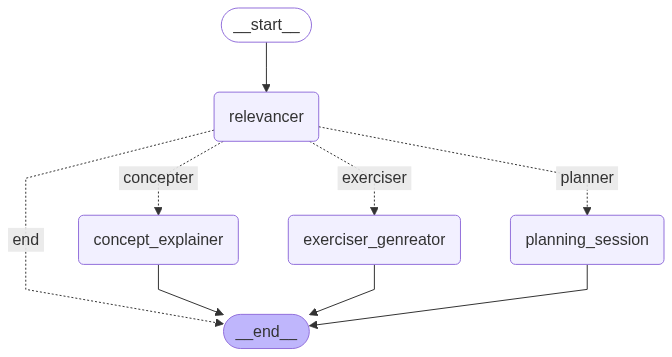

In [33]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

